# Edited By AFANDI Soufiane

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install mplfinance
import mplfinance as mpf

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
import matplotlib.dates as mdates

# Part 1: Get the data

DATA From MSFT stock (Microsof Coorporation) https://finance.yahoo.com/quote/MSFT/history?period1=511142400&period2=1671494400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true from 1986/03/14 to 2022/12/20.

Our analysis is //monthly-based// Daily-based, and all the decisions are made the first trading day of the month. For a reason which will be clarified by the following code, our analysis will start from 24 months after January 1986 and end the month before november 2022.

In [5]:
df = pd.read_csv("MSFT.csv")
df.shape

(9268, 7)

In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000
1,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200
2,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400
3,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400
4,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059723,58435200
...,...,...,...,...,...,...,...
9263,2022-12-13,261.690002,263.920013,253.070007,256.920013,256.920013,42196900
9264,2022-12-14,257.130005,262.589996,254.309998,257.220001,257.220001,35410900
9265,2022-12-15,253.720001,254.199997,247.339996,249.009995,249.009995,35560400
9266,2022-12-16,248.550003,249.839996,243.509995,244.690002,244.690002,86088100


In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000
1,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200
2,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400
3,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400
4,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059723,58435200


In [8]:
df.index = pd.to_datetime(df["Date"])
df=df.drop("Date",axis=1)

In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400
1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059723,58435200


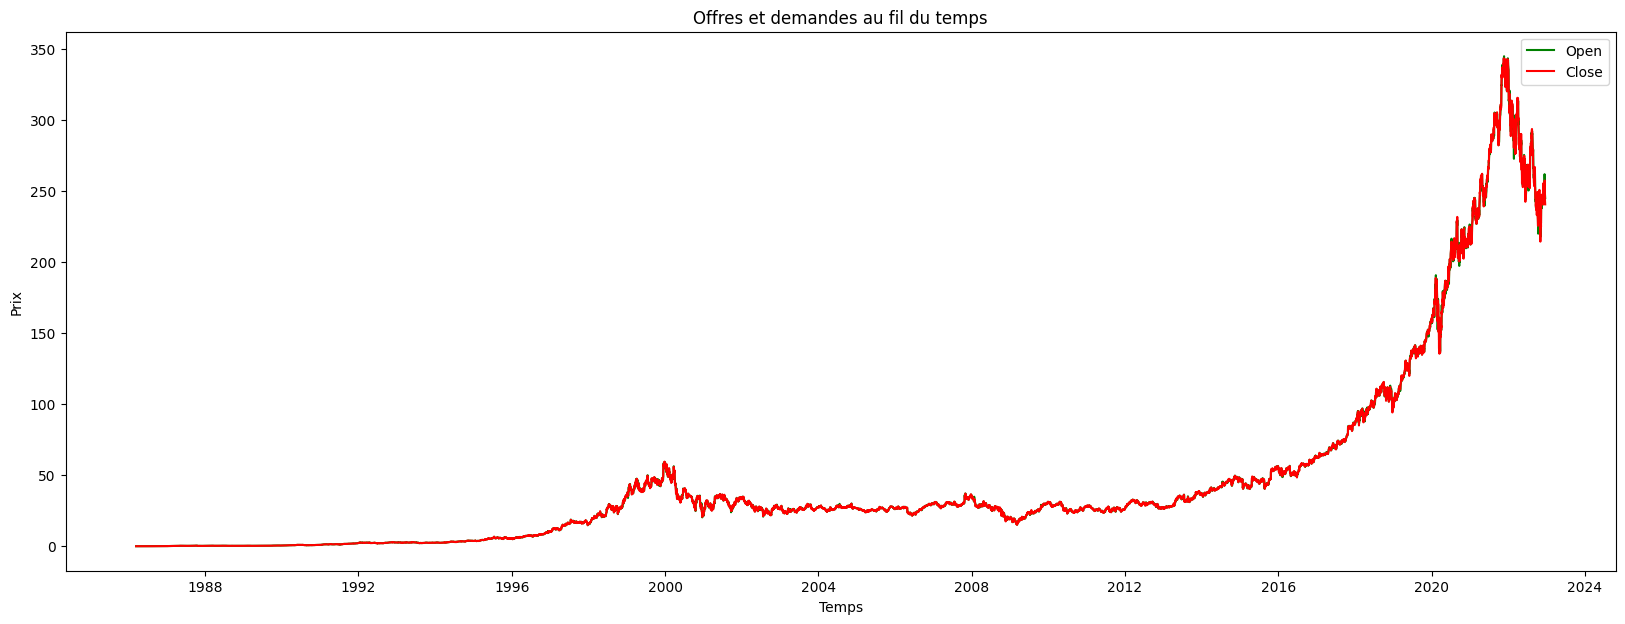

In [10]:
plt.figure(figsize=(20, 7))
# plt.plot(df['time'], df['bid'], label='Offres d\'achat')
# plt.plot(df['time'], df['ask'], label='Demandes de vente')
plt.plot(df['Open'], label='Open', color='green')
plt.plot(df['Close'], label='Close', color='red')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.title('Offres et demandes au fil du temps')
plt.legend()
plt.show()

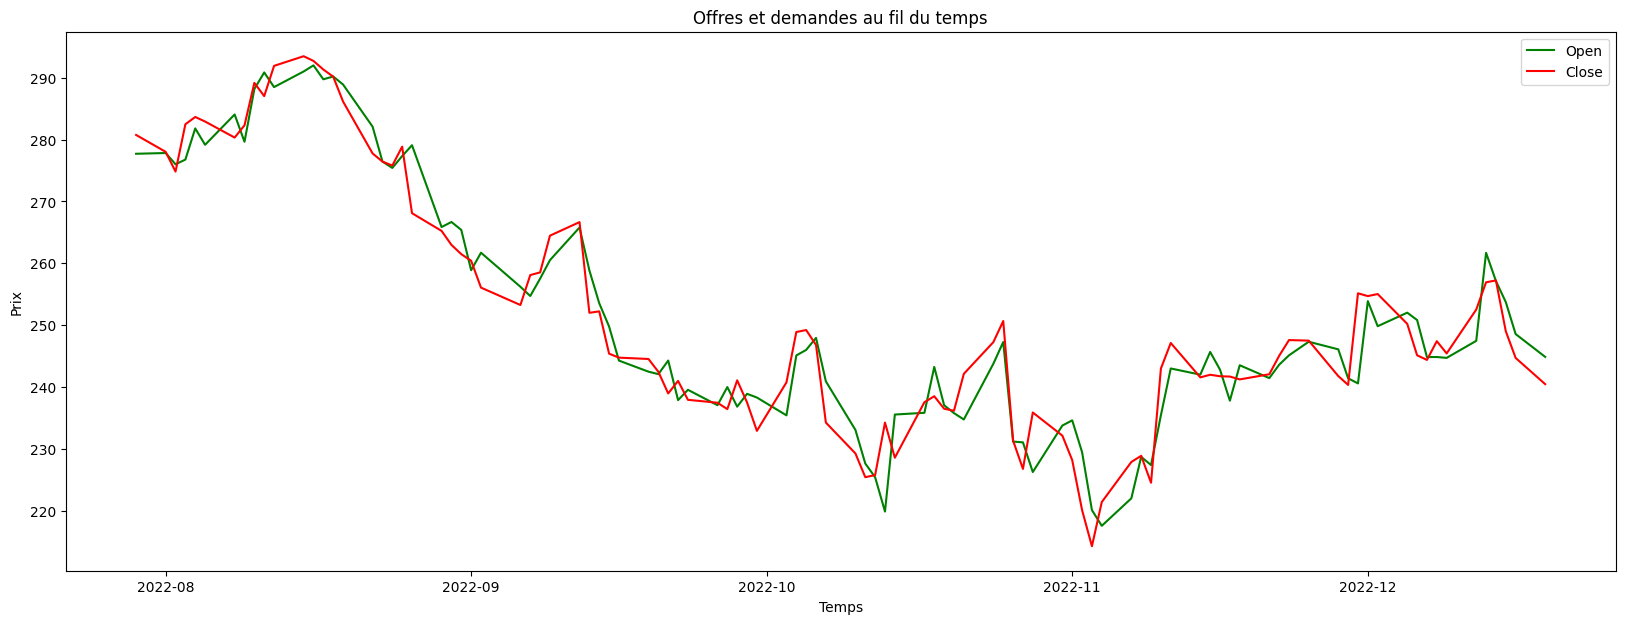

In [11]:
plt.figure(figsize=(20, 7))
plt.plot(df['Open'][-100:], label='Open', color='green')
plt.plot(df['Close'][-100:], label='Close', color='red')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.title('Offres et demandes au fil du temps')
plt.legend()
plt.show()

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\2664872683.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date_num"] = mdates.date2num(df.index.to_pydatetime())


<Figure size 2000x700 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

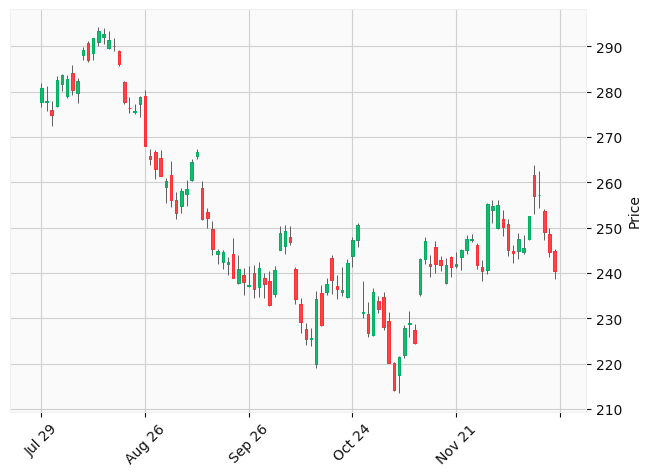

In [12]:
plt.figure(figsize=(20, 7))
# Sélectionner les colonnes à utiliser pour le graphique de chandeliers
data = df[["Open", "High", "Low", "Close"]]

# Convertir les dates en format numérique pour matplotlib
data["date_num"] = mdates.date2num(df.index.to_pydatetime())

plt.figure(figsize=(20, 10))
mpf.plot(data.iloc[-100:,:],type='candle',style='yahoo')
plt.show()

* 1- Le prix "**Open**" représente *le prix* auquel **une action a été négociée pour la première fois** lors de la séance de négociation actuelle.

* 2- Le prix "**Close**" représente *le prix* auquel **une action a été négociée pour la dernière fois** lors de la séance de négociation actuelle.

* 3- Le prix "**High**" représente *le prix* **le plus élevé** auquel **une action a été négociée** lors de la séance de négociation actuelle.

* 4- Le prix "**Low**" représente *le prix* **le plus bas** auquel **une action a été négociée** lors de la séance de négociation actuelle.

--> Les prix Open et Close donnent une idée de la tendance générale du marché pour l'action en question.

* 1- Si le prix **Close est supérieur au prix Open**, il est probable que l'action ait connu une hausse de prix pendant la séance de négociation, indiquant une tendance haussière.

* 2- Si le prix **Close est inférieur au prix Open**, il est probable que l'action ait connu une baisse de prix pendant la séance de négociation, indiquant une tendance baissière.

* 3- Les **prix High** et **Low** donnent une idée de **la volatilité du marché pour l'action en question**. 
        
     - Si l'**écart** entre les prix High et Low **est élevé**, cela indique que l'action a connu une **forte volatilité** pendant la séance de négociation. 
     - Si l'**écart** est **faible**, cela indique que l'action a connu une **faible volatilité**.

Le prix "Open" et le prix "Close" sont des prix de clôture pour une action à un moment donné, ils représentent respectivement le prix d'ouverture et le prix de clôture de l'action à la fin de la séance de négociation.

Le Bid (prix d'achat) et l'Ask (prix de vente) sont les prix auxquels les investisseurs peuvent acheter ou vendre des actions sur le marché. Le Bid est le prix maximum auquel un investisseur est prêt à acheter une action, et l'Ask est le prix minimum auquel un investisseur est prêt à vendre une action. La différence entre le Bid et l'Ask est appelée le spread.

Il existe une relation entre le prix Open, Close, Bid et Ask:

-Le prix d'ouverture (Open) est généralement proche du dernier prix d'achat (Bid) de la séance précédente, car il est généralement déterminé par les transactions qui ont eu lieu à la fin de la séance précédente.

-Le prix de clôture (Close) est généralement proche du dernier prix de vente (Ask) de la séance en cours, car il est généralement déterminé par les transactions qui ont eu lieu à la fin de la séance en cours.

Il est important de noter que ces informations sont des indications générales et que les prix réels peuvent varier en fonction de la liquidité du marché, de l'offre et de la demande, de la volatilité, des nouvelles et des rumeurs, et d'autres facteurs.

(!!!) Il est important de noter que ces informations ne sont qu'une indication de la tendance et de la volatilité du marché pour l'action en question et ne peuvent pas être utilisées seules pour prendre des décisions d'investissement. Il est important de considérer d'autres facteurs tels que les tendances économiques, les résultats financiers de l'entreprise, etc. pour une analyse plus complète.

La **séance de négociation** est **la période de temps pendant laquelle les actions d'une entreprise sont achetées et vendues sur un marché boursier**. 

Les séances de négociation varient en fonction du marché boursier, mais généralement, elles ont lieu pendant les heures de bureau normales. Par exemple, sur le NYSE (New York Stock Exchange) et le NASDAQ (National Association of Securities Dealers Automated Quotations) aux États-Unis, les séances de négociation ont lieu de 9h30 à 16h00, heure de l'est.

Pendant la séance de négociation, les investisseurs peuvent acheter et vendre des actions d'une entreprise auprès d'un courtier ou sur un système électronique de négociation, comme un système de négociation automatisé (ATS). Les investisseurs peuvent également utiliser des ordres automatisés pour acheter ou vendre des actions en fonction de certains critères, comme le prix ou le volume.

**Les prix des actions sont déterminés par l'offre et la demande**. Lorsque la demande est élevée pour une action, son prix augmente, et lorsque la demande est faible, son prix baisse. Les investisseurs utilisent des informations financières, économiques et d'autres facteurs pour évaluer l'offre et la demande d'une action et décider s'il faut acheter ou vendre.

Il est important de noter que les marchés boursiers peuvent être volatils et que les prix des actions peuvent fluctuer considérablement d'une journée à l'autre. Les investisseurs doivent donc être prêts à prendre des risques et à être patients pour réaliser des profits à long terme.

------> donc réellement notre objectif et d'étudier ce risque, et de le miniminer le plus maximum possibles avec les méthodes de machine learning.

** (?) est qu'on peut consédérer cette dataset comme etant une série chronologique 'timeseries'?**

Un dataset de données boursières peut être considéré comme une série chronologique (ou "time series") si les données sont organisées par date et heure. Cela signifie que les données sont organisées de manière à ce qu'une ligne de données corresponde à une date et une heure spécifiques, et qu'il existe une colonne qui indique la date et l'heure pour chaque ligne de données.

Il est important de noter que les données de séries chronologiques ont des propriétés uniques qui les différencient des données non chronologiques, comme une tendance chronologique, une saisonnalité et une corrélation temporelle. Cela peut affecter les méthodes utilisées pour analyser les données et les modèles utilisés pour les prévoir. Les séries chronologiques sont souvent utilisées pour faire des prévisions à court et à long terme, notamment dans les domaines de la finance, de l'économie, de la météorologie, etc.

Il existe plusieurs méthodes pour appliquer les propriétés uniques des séries chronologiques à un dataset de données boursières, voici quelques exemples :

**1-** Analyse de tendance : pour identifier les tendances à long terme dans les données, comme une tendance à la hausse ou à la baisse des prix des actions. Cela peut aider à prévoir les tendances futures.

**2-** Analyse de saisonnalité : pour identifier les modèles récurrents dans les données, comme des hausses de prix pendant certaines saisons de l'année. Cela peut aider à prévoir les modèles futurs.

**3-** Analyse de corrélation temporelle : pour identifier les relations entre les données à différents moments dans le temps, comme les relations entre les prix des actions et les taux d'intérêt. Cela peut aider à prévoir les relations futures.

**4-** Analyse de la stationnarité: pour identifier si la série chronologique est statique ou non, cela veut dire qu'elle possède une moyenne et une variance constante. Cette analyse est importante pour choisir le modèle de prévision à utiliser.

En utilisant ces méthodes, vous pouvez mieux comprendre les données et les utiliser pour construire un modèle de prédiction plus précis. Par exemple, si vous identifiez une tendance à la hausse des prix des actions sur une période de temps donnée, vous pourriez utiliser cette information pour prévoir une tendance à la hausse des prix des actions à l'avenir. De même, si vous identifiez une saisonnalité dans les données, vous pourriez utiliser cette information pour prévoir les modèles futurs.

Il est important de noter que ces méthodes peuvent être combinées pour une analyse plus complète et qu'il existe d'autres méthodes pour analyser les séries chronologiques comme l'analyse de séries chronologiques décomposée qui permet de dissocier les tendances, saisonnalités et résidus. Il est important de noter qu'il est nécessaire d'avoir un jeu de données suffisant pour utiliser ces méthodes.

#### 1- Analyse de tendance :

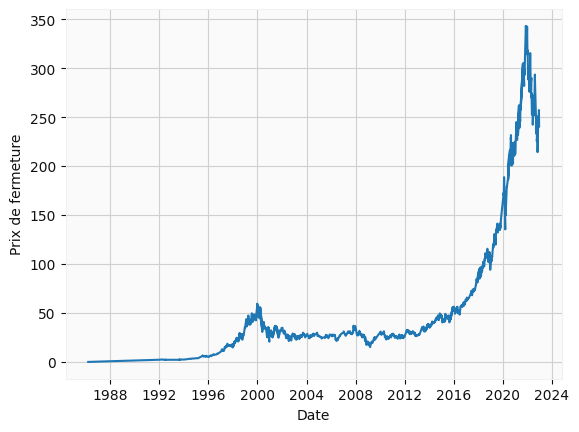

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Tracer les données
plt.plot(df.index, df["Close"])
plt.xlabel("Date")
plt.ylabel("Prix de fermeture")
plt.show()

#### 2- Analyse de saisonnalité:

In [14]:
d = data.copy()
d['date'] = d.index
# Ajouter une colonne pour les mois
d['month'] = d['date'].apply(lambda x: x.month)

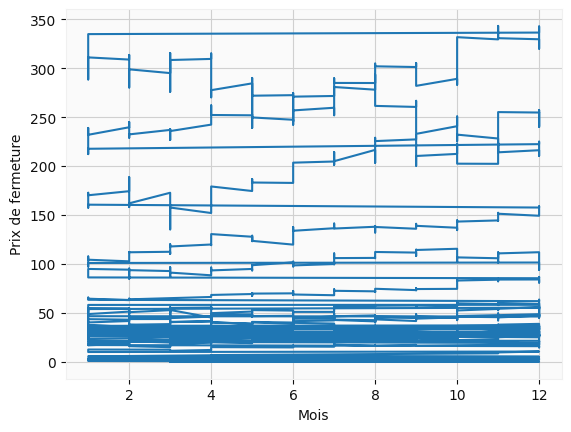

In [15]:
# Tracer les données
plt.plot(d["month"], d["Close"])
plt.xlabel("Mois")
plt.ylabel("Prix de fermeture")
plt.show()

####  4- Analyse de la stationnarité :

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
# Appliquer la fonction d'analyse de stationnarité
result = adfuller(d["Close"])

# Afficher les résultats
print("Test statistic: ",result[0])
print("p-value: ",result[1])
print("Critical Values:")
for key,value in result[4].items():
    print(f'   {key}, {value}')

Test statistic:  1.9089170831119033
p-value:  0.998542231003592
Critical Values:
   1%, -3.43105868034315
   5%, -2.8618531916783914
   10%, -2.566936706861722


Les principaux résultats de la fonction adfuller() sont :

**Test statistic :** C'est la valeur de test statistique obtenue. Si la valeur est supérieure à la valeur critique, il est probable que la série chronologique ne soit pas statique.

**p-value :** C'est la probabilité d'obtenir un test statistic aussi élevé ou plus élevé que celui observé, lorsque la série chronologique est statique. Si la valeur est supérieure à un seuil de signification (généralement 0,05), il est probable que la série chronologique soit statique.

**Critical Values :** Il fournit des valeurs critiques pour différents niveaux de confiance (1%, 5% et 10%). Si la valeur de test statistic est inférieure à la valeur critique associée à un certain niveau de confiance, il est probable que la série chronologique soit statique.


En résumé, si la valeur de test statistic est inférieure à la valeur critique associée à un certain niveau de confiance et si la valeur p-value est inférieure à un seuil de signification, il est probable que la série chronologique soit statique et il est possible d'utiliser les modèles de prévisions appropriés pour cette série. Sinon, il est nécessaire de faire une transformation pour rendre la série statique avant

## 1. Using Random Forest - Classification based

In [18]:
df['price_change'] = df['Close'] - df['Open']

In [19]:
df['price_change'].min(), df['price_change'].max()

(-15.67001300000004, 22.079985999999963)

In [20]:
df['target'] = np.where(df["price_change"] > 0, 1, 0)

In [21]:
sum(np.where(df["price_change"] > 0, 1, 0))

4587

In [22]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,price_change,target
Date,,,,,,,,
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000,0.003472,1
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200,0.001737,1
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400,-0.002605,0
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400,-0.001736,0
1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059723,58435200,-0.002604,0


In [23]:
X = df[['Open', 'Close']]
y = df['target']

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [26]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_pred = clf.predict(X_test)

In [28]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(acc*100))

Accuracy: 89.16


In [29]:
confusion_matrix(y_test, y_pred)

array([[838,  88],
       [113, 815]], dtype=int64)

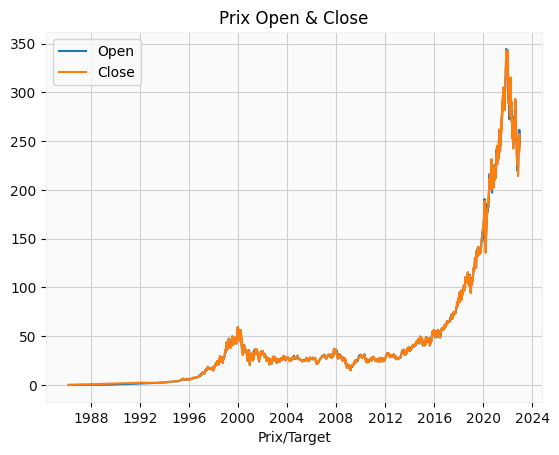

In [30]:
plt.plot(df['Open'], label='Open')
plt.plot(df['Close'], label='Close')
plt.legend()
plt.xlabel('Temps')
plt.xlabel('Prix/Target')
plt.title('Prix Open & Close')
plt.show()

In [31]:
# fig, ax = plt.subplots()
# ax.plot(df['Open'], label='Open')
# ax.plot(df['Close'], label='Close')
# # plt.plot(df['target'], 'o', markersize=3, label='target')


# # Tracé des lignes verticales pour les prédictions
# for date, prediction in zip(df.index[100:], df['target'][100:]):    
#     if prediction == 1:
#         ax.axvline(date, color='green', linestyle='--', linewidth=1)
#     else:
#         ax.axvline(date, color='red', linestyle='--', linewidth=1)

# plt.legend()
# plt.xlabel('Temps')
# plt.xlabel('Prix/Target')
# plt.title('Prix Open & Close')
# plt.show()

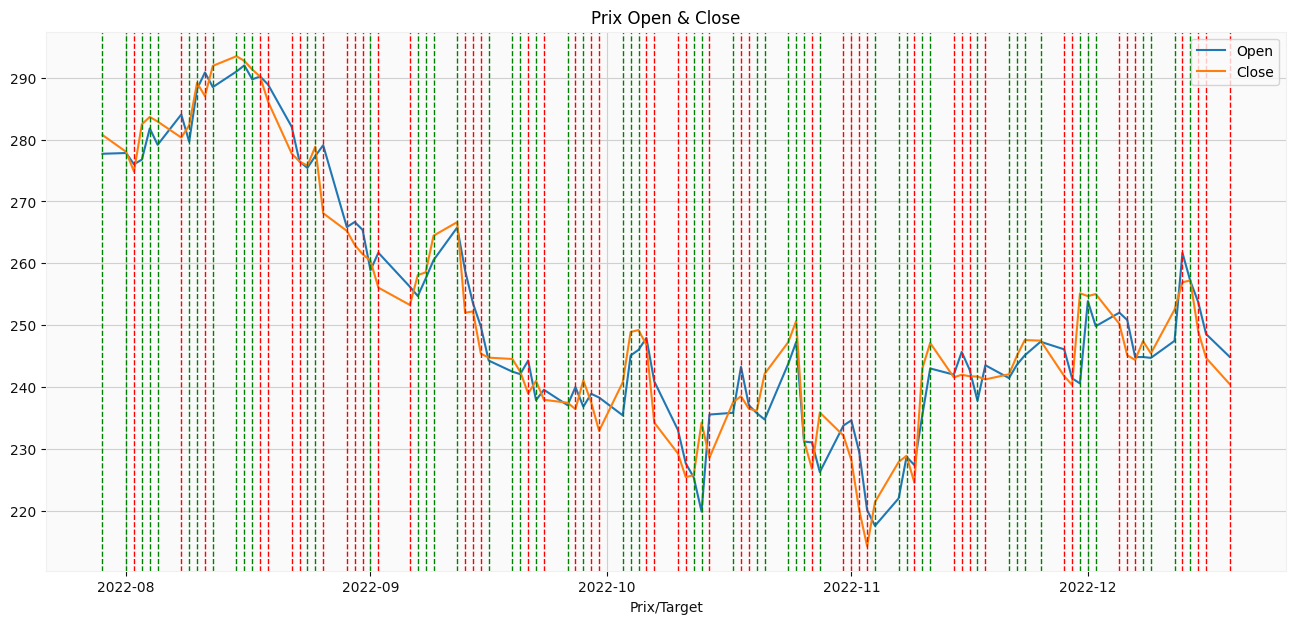

In [32]:
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(df['Open'][-100:], label='Open')
ax.plot(df['Close'][-100:], label='Close')
# plt.plot(df['target'], 'o', markersize=3, label='target')


# Tracé des lignes verticales pour les prédictions
for date, prediction in zip(df.index[-100:], df['target'][-100:]):    
    if prediction == 1:
        ax.axvline(date, color='green', linestyle='--', linewidth=1)
    else:
        ax.axvline(date, color='red', linestyle='--', linewidth=1)

plt.legend()
plt.xlabel('Temps')
plt.xlabel('Prix/Target')
plt.title('Prix Open & Close')
plt.show()

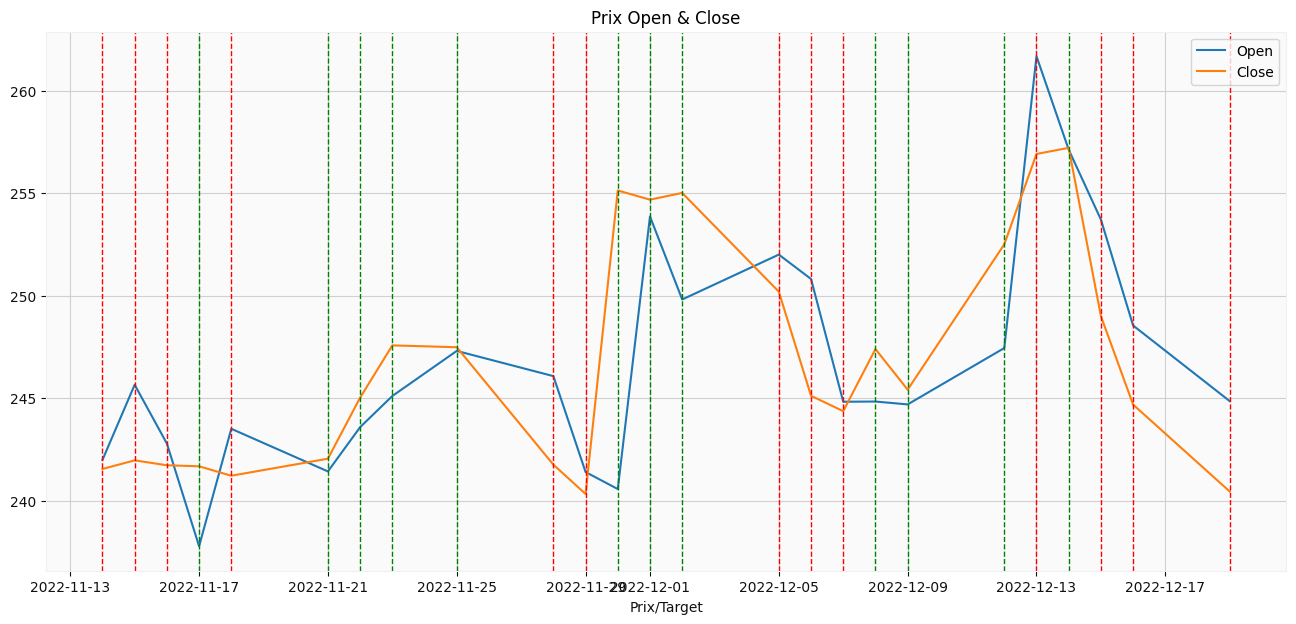

In [33]:
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(df['Open'][-25:], label='Open')
ax.plot(df['Close'][-25:], label='Close')

# Tracé des lignes verticales pour les prédictions
for date, prediction in zip(df.index[-25:], df['target'][-25:]):    
    if prediction == 1:
        ax.axvline(date, color='green', linestyle='--', linewidth=1)
    else:
        ax.axvline(date, color='red', linestyle='--', linewidth=1)

plt.legend()
plt.xlabel('Temps')
plt.xlabel('Prix/Target')
plt.title('Prix Open & Close')
plt.show()

### Afficher les données de la différence logarithmique


Cette méthode consiste à calculer la différence logarithmique entre les prix consécutifs. Cela permet de visualiser les variations de prix en pourcentage en utilisant des valeurs relatives.

L'utilisation de la différence logarithmique pour normaliser les données est une technique courante en analyse financière car elle permet de visualiser les variations de prix en pourcentage en utilisant des valeurs relatives. Cela peut être utile pour les données qui ont **des tendances à augmenter au fil du temps**, comme c'est souvent le cas pour les données de prix des actions.

La différence logarithmique est calculée en prenant le logarithme naturel de chaque valeur de prix, puis en calculant la différence entre les valeurs consécutives. Cela permet de calculer les taux de croissance relative entre les périodes consécutives.

En utilisant la différence logarithmique, on peut mieux visualiser les tendances de croissance des prix des actions. Cela permet de mieux comprendre les changements de prix, **même si les prix augmentent de manière significative au fil du temps**. En utilisant cette méthode, vous pouvez facilement comparer les tendances de croissance entre les différentes actions ou entre les différents périodes.

In [34]:
df["Open_logdiff"] = np.log(df["Open"]).diff()
df["Close_logdiff"] = np.log(df["Close"]).diff()
df["High_logdiff"] = np.log(df["High"]).diff()
df["Low_logdiff"] = np.log(df["Low"]).diff()

la fonction `diff()` prend en entrée un DataFrame ou une série de données et renvoie un nouveau DataFrame ou une nouvelle série de données où chaque valeur est **la différence entre la valeur courante et la valeur précédente**.

Cela permet de mieux comprendre les changements de prix, même si les prix augmentent de manière significative au fil du temps. En utilisant cette méthode, vous pouvez facilement compare

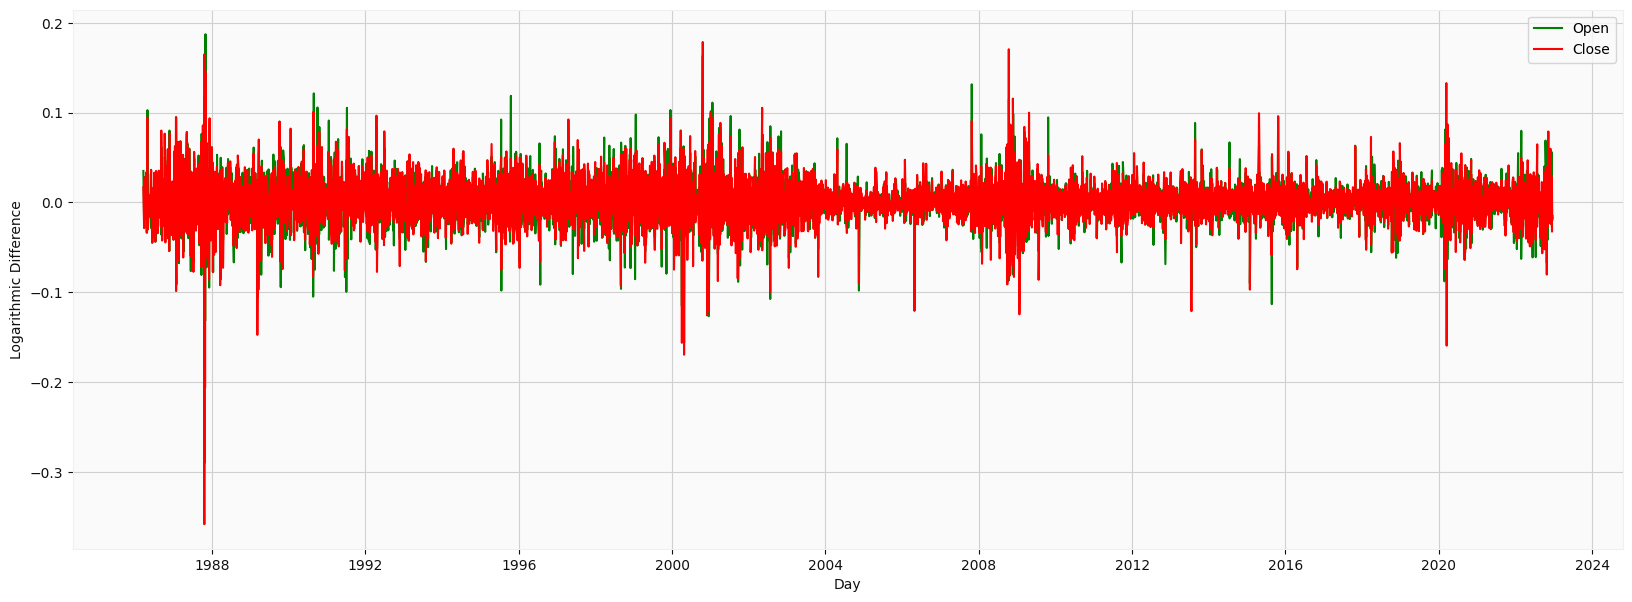

In [35]:
plt.figure(figsize=(20, 7))

plt.plot(df["Open_logdiff"], label="Open",color='green')
plt.plot(df["Close_logdiff"], label="Close",color='red')
plt.xlabel("Day")
plt.ylabel("Logarithmic Difference")
plt.legend()
plt.show()

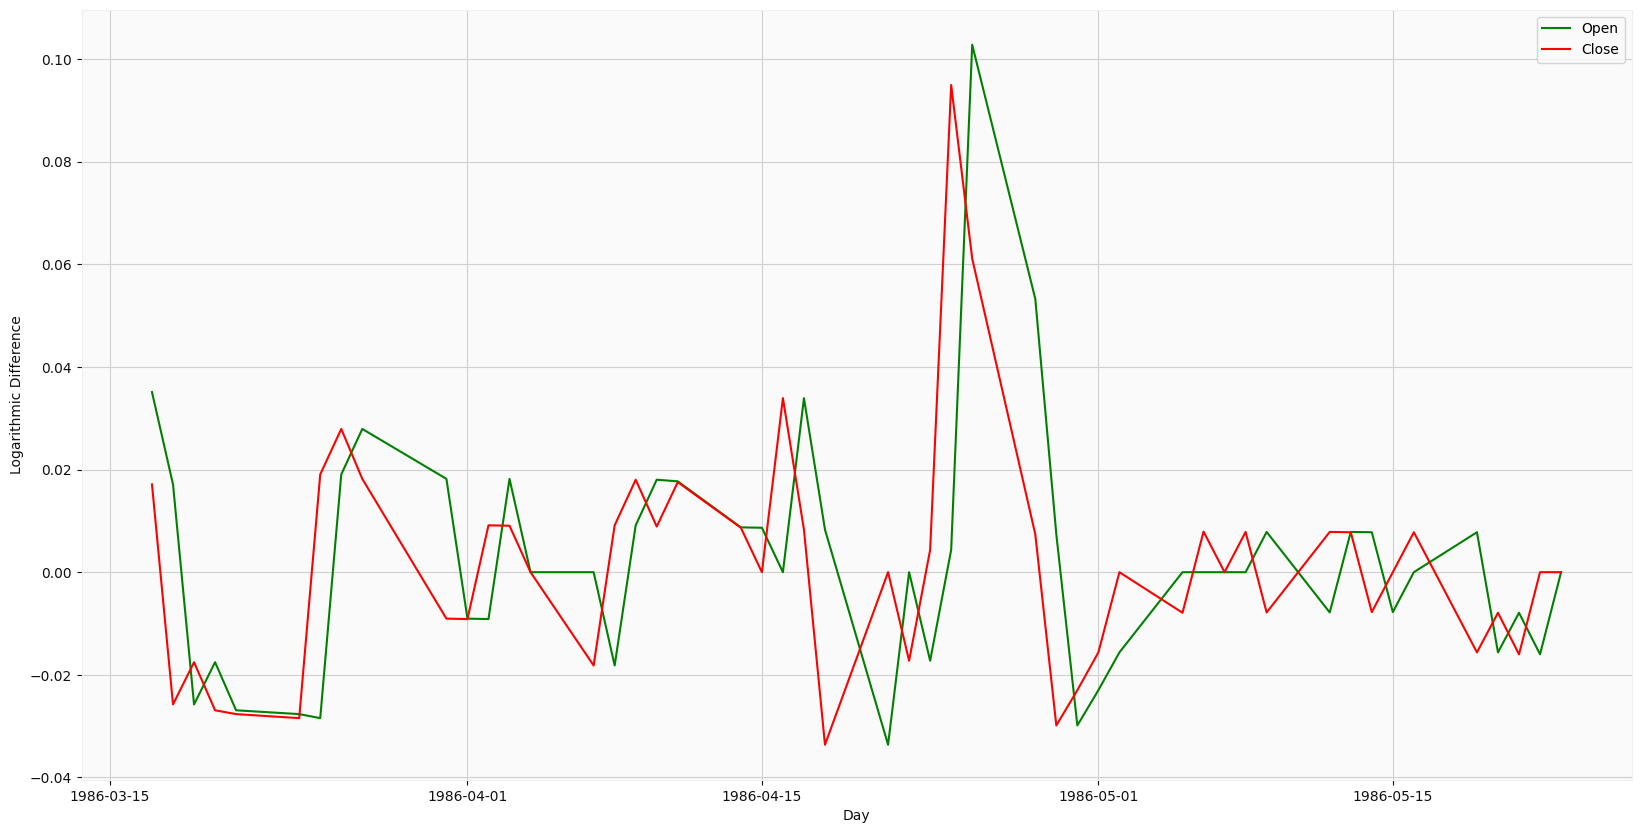

In [36]:
plt.figure(figsize=(20, 10))

plt.plot(df["Open_logdiff"][:50], label="Open", color='green')
plt.plot(df["Close_logdiff"][:50], label="Close", color='red')
plt.xlabel("Day")
plt.ylabel("Logarithmic Difference")
plt.legend()
plt.show()

### afficher les prix d'ouverture, de haut, de bas et de clôture sous forme de rectangles dans un graphique de trading.

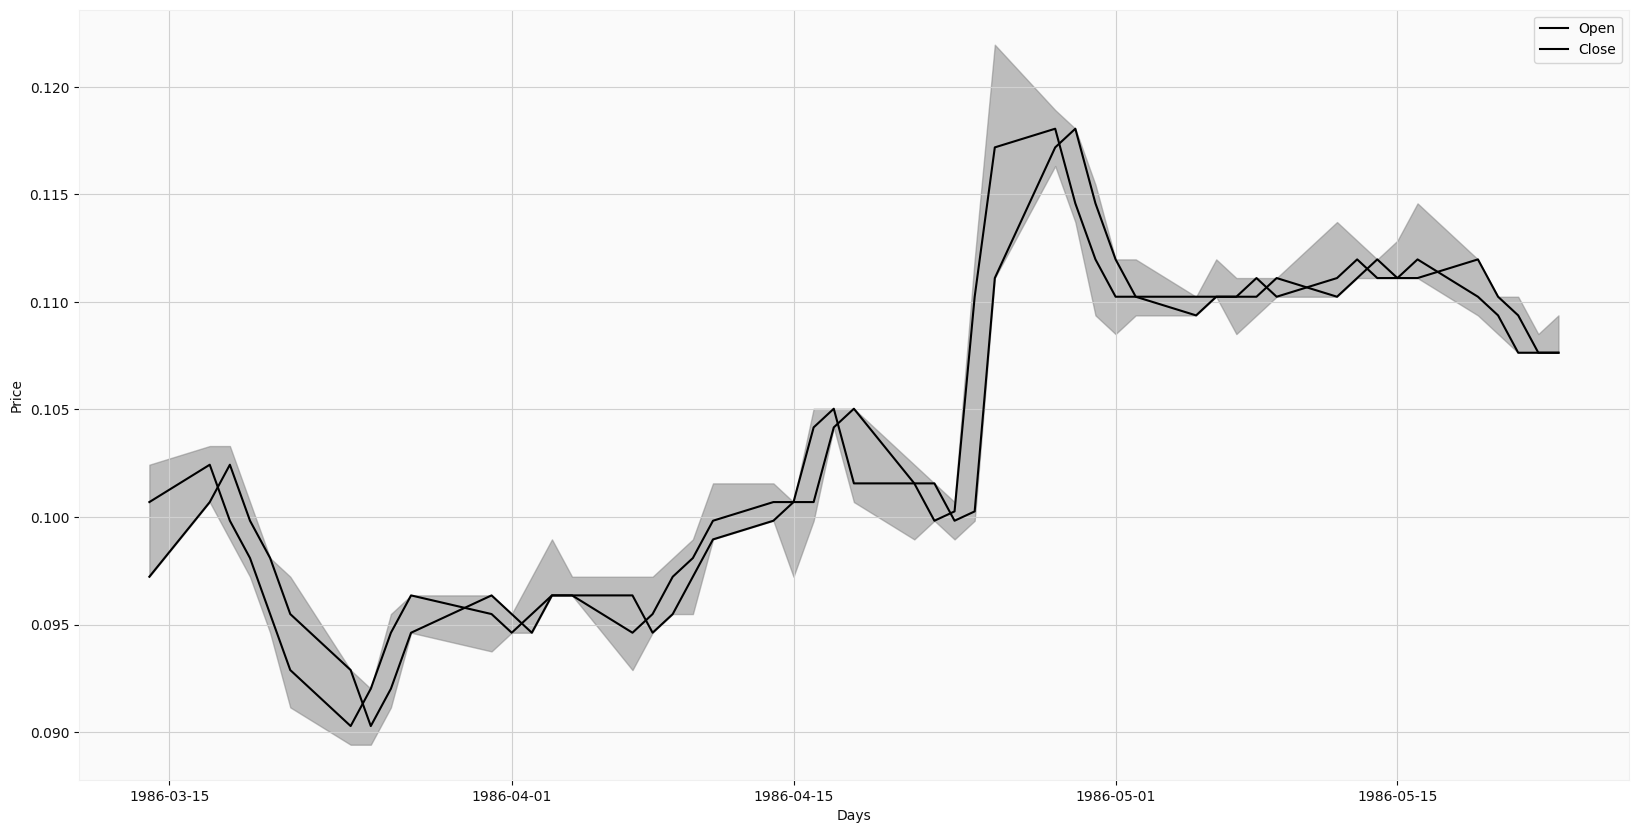

In [37]:
# Afficher les données de trading
plt.figure(figsize=(20, 10))

plt.plot(df["Open"][:50], color='black', label='Open')
plt.plot(df["Close"][:50], color='black', label='Close')
plt.fill_between(df.index[:50], df["Low"][:50], df["High"][:50], color='gray', alpha=0.5)
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

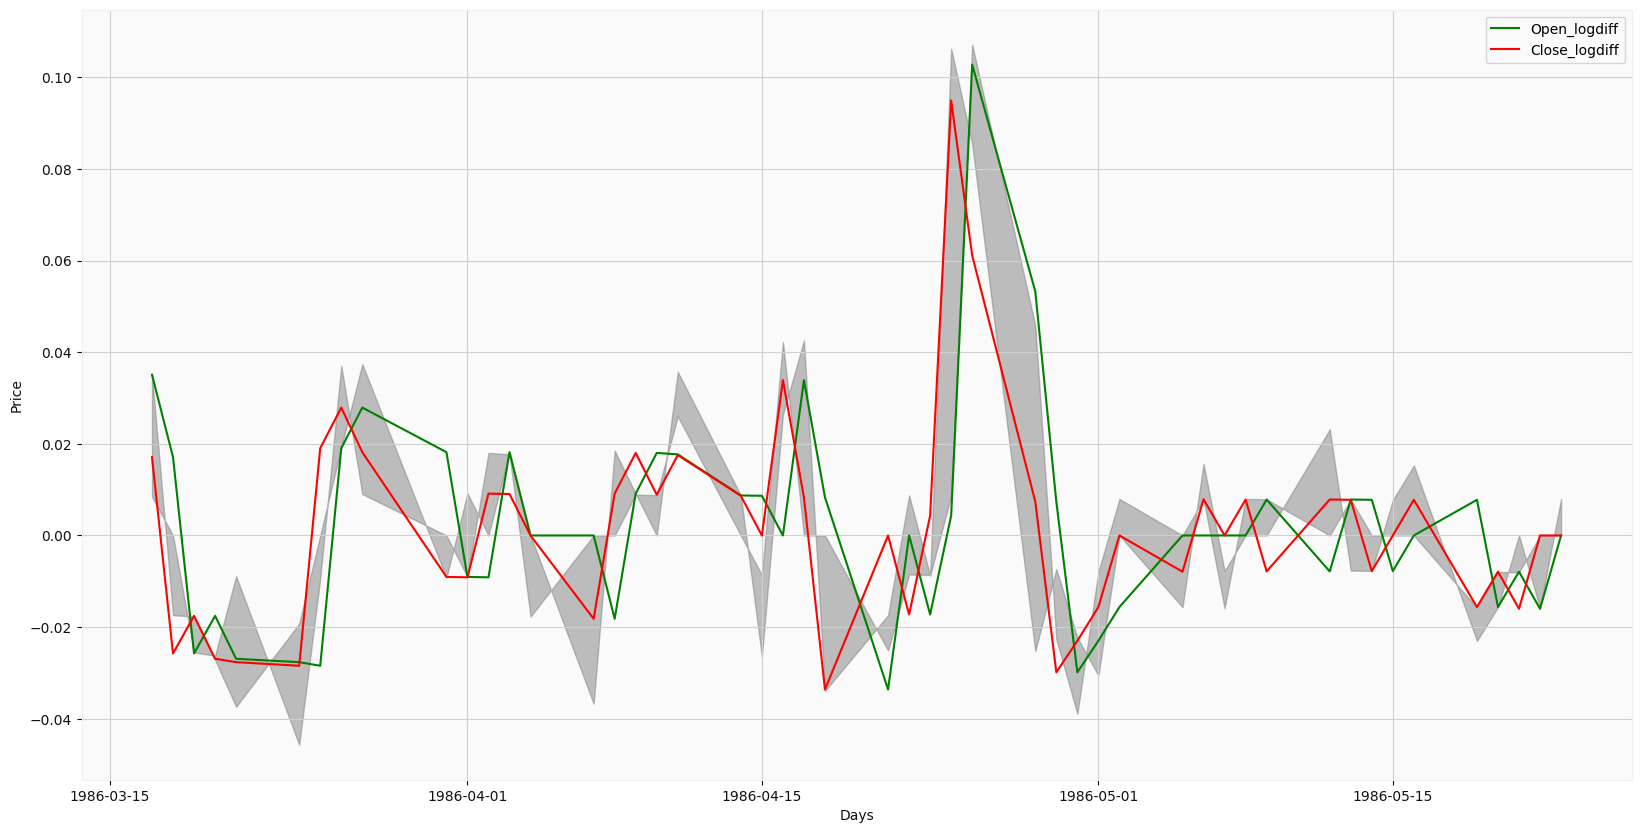

In [38]:
plt.figure(figsize=(20, 10))

plt.plot(df["Open_logdiff"][:50], color='green', label='Open_logdiff')
plt.plot(df["Close_logdiff"][:50], color='red', label='Close_logdiff')
plt.fill_between(df.index[:50], df["Low_logdiff"][:50], df["High_logdiff"][:50], color='gray', alpha=0.5)
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

### Graphique de chandeliers de retournement de tendance

In [39]:
import matplotlib.dates as mdates

# Sélectionner les colonnes à utiliser pour le graphique de chandeliers
data = df[["Open", "High", "Low", "Close"]]

# Convertir les dates en format numérique pour matplotlib
data["date_num"] = mdates.date2num(df.index.to_pydatetime())

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\3036796844.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date_num"] = mdates.date2num(df.index.to_pydatetime())


<Figure size 2000x1000 with 0 Axes>

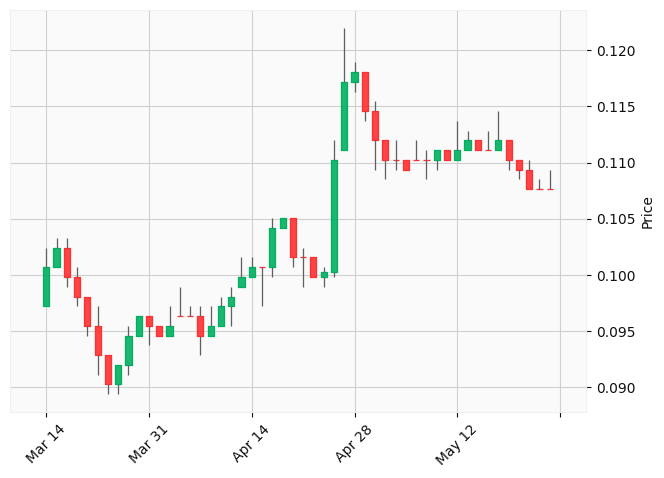

In [40]:
plt.figure(figsize=(20, 10))
mpf.plot(data.iloc[:50,:],type='candle',style='yahoo')
plt.show()

<Figure size 2000x1000 with 0 Axes>

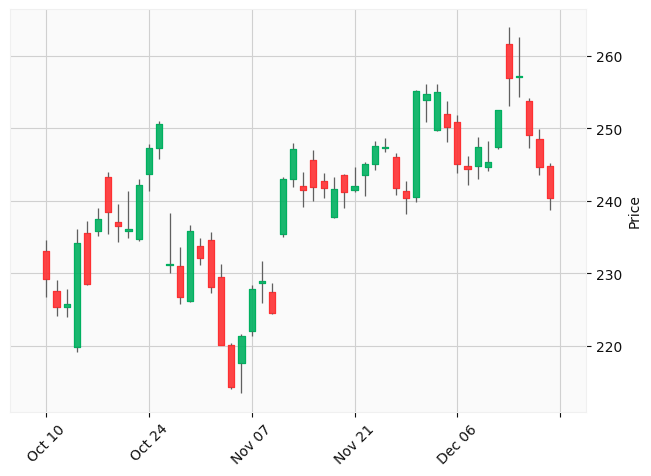

In [41]:
plt.figure(figsize=(20, 10))
mpf.plot(data.iloc[-50:,:],type='candle',style='yahoo')
plt.show()

la fonction addplot() permet d'ajouter des données supplémentaires sur votre graphique de chandeliers.

In [42]:
# !pip show mplfinance

In [43]:
# !pip show matplotlib

In [44]:
# !pip install --upgrade mplfinance
# !pip install --upgrade matplotlib

In [45]:
# !pip list

<Figure size 2000x1500 with 0 Axes>

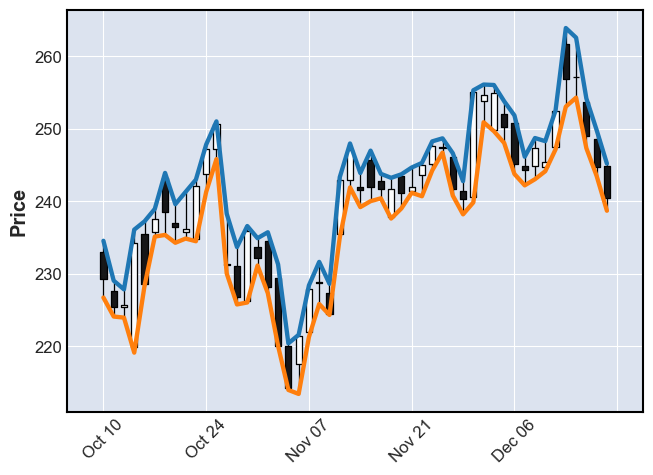

In [46]:
plt.figure(figsize=(20, 15))
extra_plot  = mpf.make_addplot(data.loc[str(data.index[-50]):, ["High","Low"]])
mpf.plot(data[str(data.index[-50]):], type="candle", addplot=extra_plot)
plt.show()

When you look at the candles and the dates, it is clear that there are some missing dates there. That naturally comes from the fact that the markets are closed on the weekends and some special days. If you want to take this into account, you can provide an extra argument to the plot function `show_nontrading=True`.

<Figure size 2000x1500 with 0 Axes>

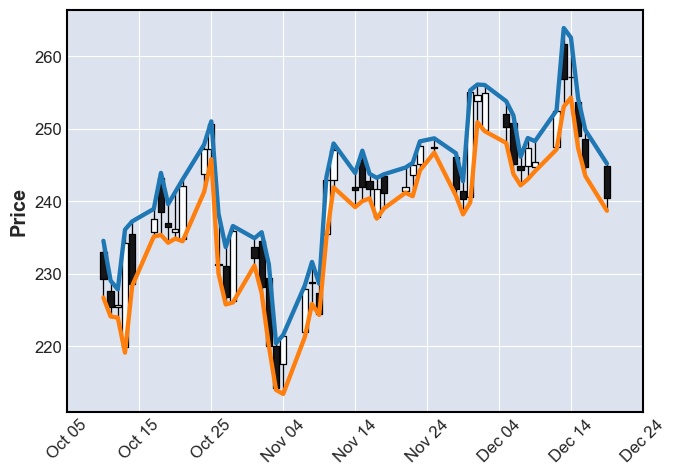

In [47]:
plt.figure(figsize=(20, 15))
extra_plot  = mpf.make_addplot(data.loc[str(data.index[-50]):, ["High","Low"]])
mpf.plot(data[str(data.index[-50]):], type="candle", addplot=extra_plot, show_nontrading=True)
plt.show()

In [48]:
data['Volume'] = df['Volume']

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\3563353781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volume'] = df['Volume']


Let’s add even more information to the plot. First, there is a handy argument we can pass into the plot function — mav — which will automatically add any simple moving averages we want. For this plot, let’s take the 10- and 20-day MAs. Secondly, we can also add the traded volume.

<Figure size 2000x1500 with 0 Axes>

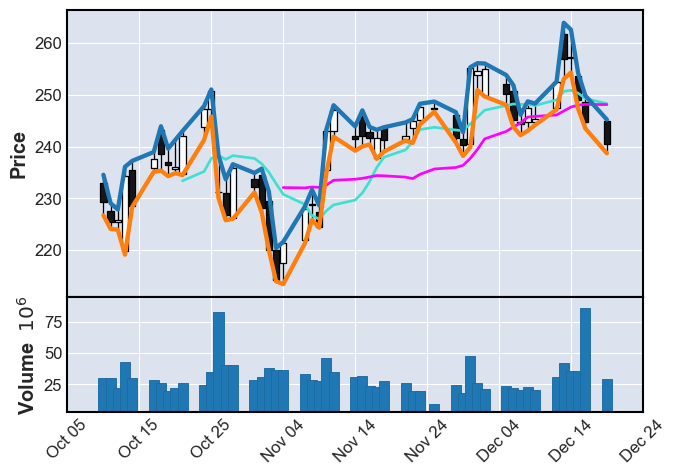

In [49]:
plt.figure(figsize=(20, 15))
extra_plot  = mpf.make_addplot(data.loc[str(data.index[-50]):, ["High","Low"]])
mpf.plot(data[str(data.index[-50]):], type="candle", addplot=extra_plot, show_nontrading=True, mav=(10, 20), volume=True)
plt.show()

In [50]:
# plt.figure(figsize=(20, 10))
# mpf.plot(data.iloc[:,:-2],type='candle', addplot={"name":"target","data":data['target'],'type':'scatter'})
# # mpf.plot(data.iloc[-50:,:],type='candle',style='yahoo')
# plt.show()

In [51]:
# # Création des séries de données pour chaque classe
# stay_data = data[data['target'] == 1]
# leave_data = data[data['target'] == 0]

# # Tracé du graphe
# # plt.bar(stay_data['date'], stay_data['target'], color='green')
# # plt.bar(leave_data['date'], leave_data['target'], color='red')

# plt.bar(data.index, stay_data['target'], color='green')
# plt.bar(data.index, leave_data['target'], color='red')


# # Configuration du graphe
# plt.xlabel('Date')
# plt.ylabel('Prediction')

In [52]:
# # Tracé des données de chandeliers
# fig, ax = mpf.plot(data[str(data.index[-50]):], type="candle")

# # Tracé des lignes verticales pour les prédictions
# for date, prediction in zip(data.index[-50:], data['target'][-50:]):    
#     if prediction == 1:
#         ax.axvline(date, color='green', linestyle='--')
#     else:
#         ax.axvline(date, color='red', linestyle='--')

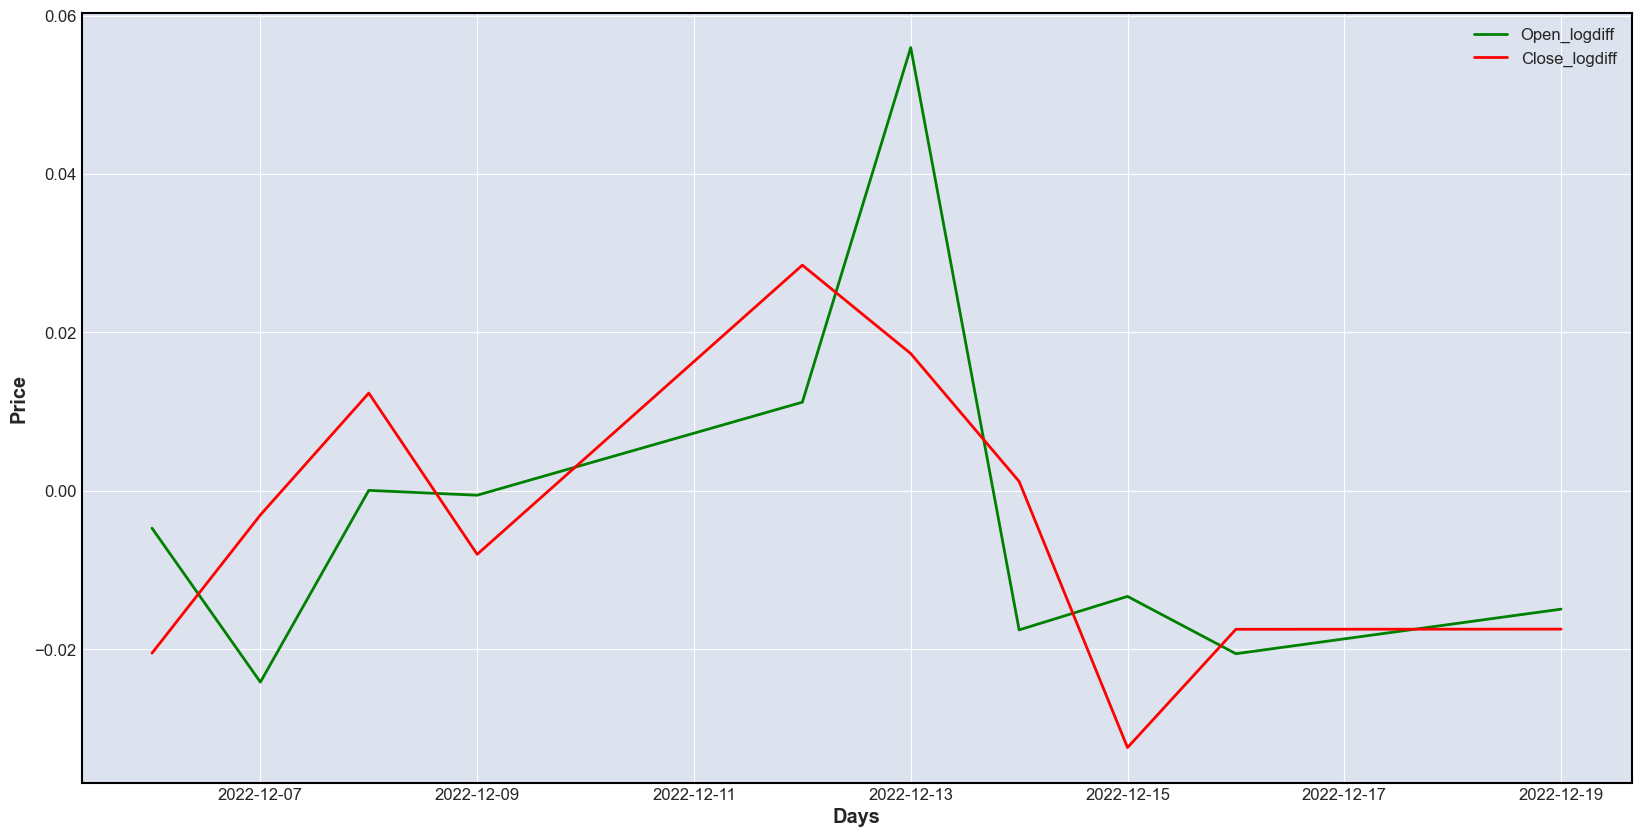

In [53]:
plt.figure(figsize=(20, 10))
plt.plot(df["Open_logdiff"][-10:], color='green', label='Open_logdiff')
plt.plot(df["Close_logdiff"][-10:], color='red', label='Close_logdiff')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()

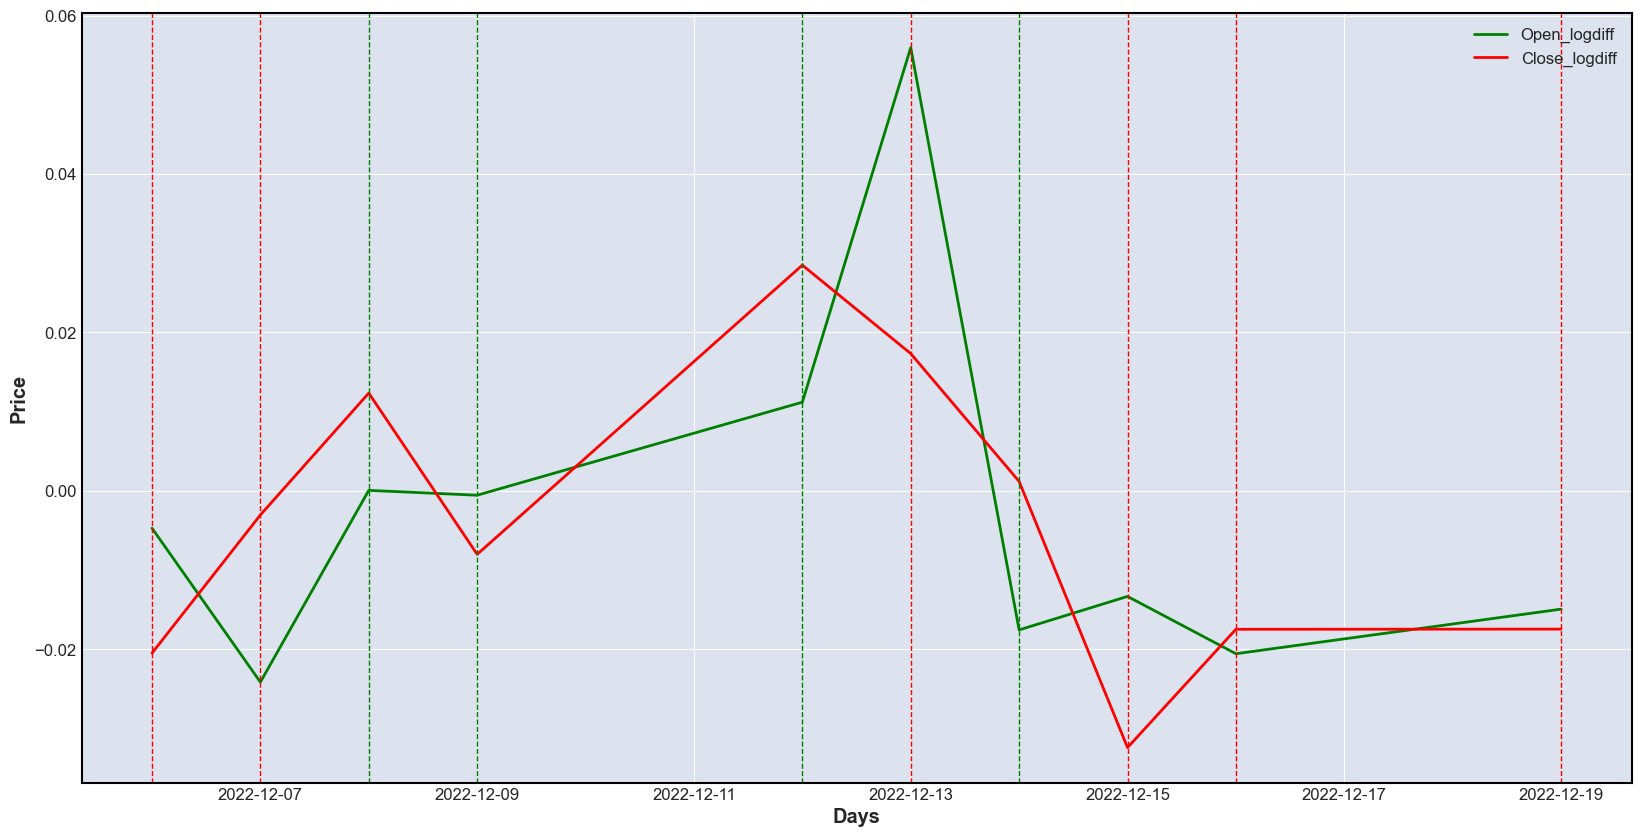

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df["Open_logdiff"][-10:], color='green', label='Open_logdiff')
ax.plot(df["Close_logdiff"][-10:], color='red', label='Close_logdiff')


# Tracé des lignes verticales pour les prédictions
for date, prediction in zip(data.index[-10:], df['target'][-10:]):    
    if prediction == 1:
        ax.axvline(date, color='green', linestyle='--', linewidth=1)
    else:
        ax.axvline(date, color='red', linestyle='--', linewidth=1)

ax.set_xlabel('Days')
ax.set_ylabel('Price')
plt.legend()

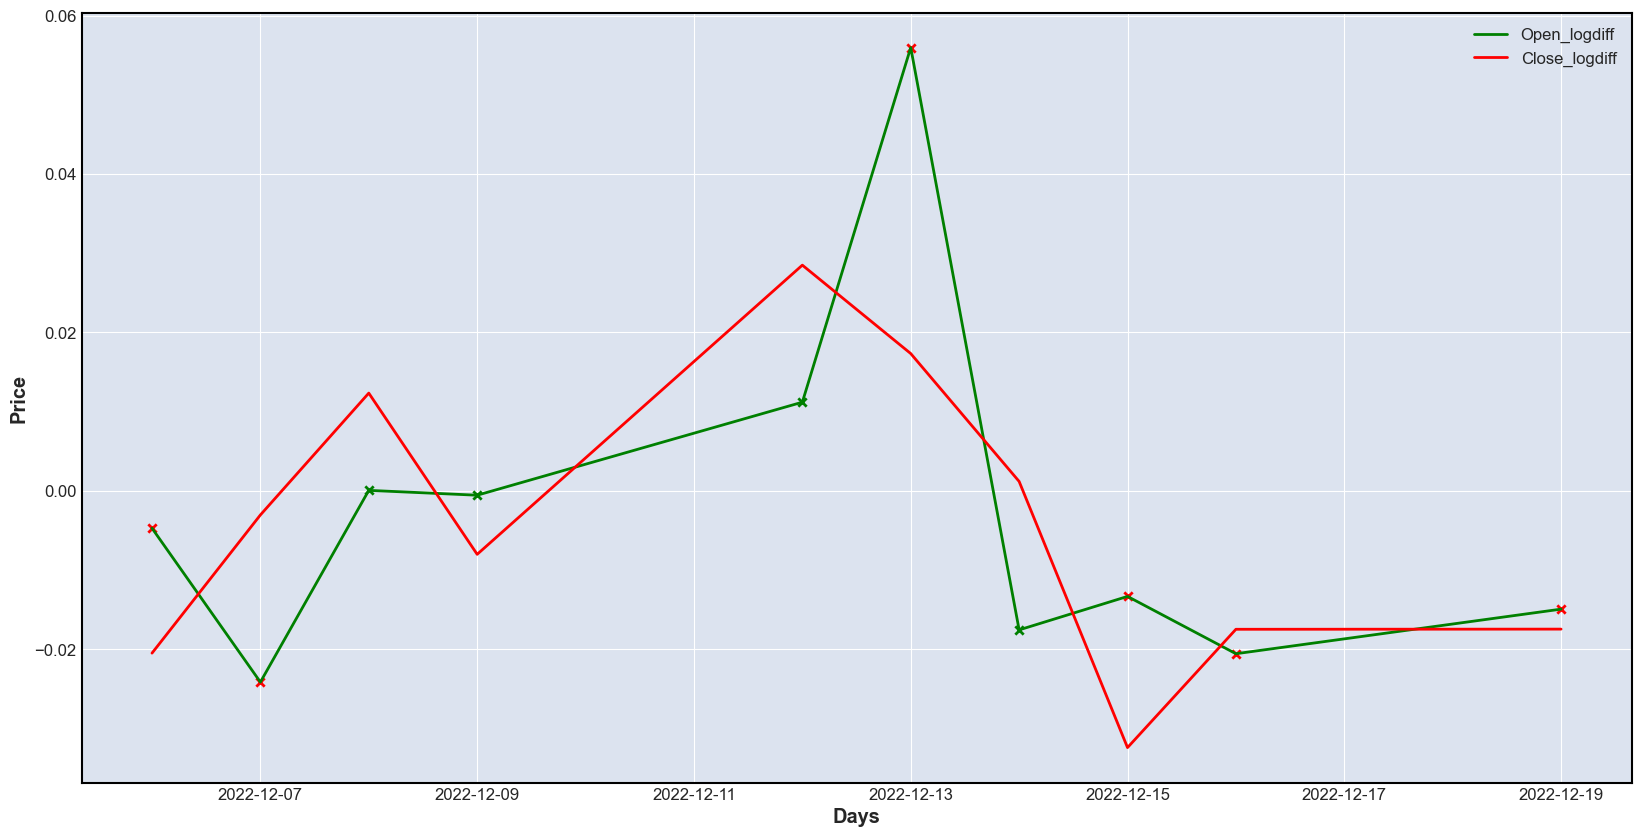

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df["Open_logdiff"][-10:], color='green', label='Open_logdiff')
ax.plot(df["Close_logdiff"][-10:], color='red', label='Close_logdiff')


# Tracé des lignes verticales pour les prédictions
for date, prediction in zip(data.index[-10:], df['target'][-10:]):    
    if prediction == 1:
        ax.scatter(date, df.loc[df.index==date,'Open_logdiff'], color='green', marker='x')
    else:
        ax.scatter(date, df.loc[df.index==date,'Open_logdiff'], color='red', marker='x')

ax.set_xlabel('Days')
ax.set_ylabel('Price')
plt.legend()

Les rectangles rouges et verts dans un graphique de chandeliers sont utilisés pour **représenter la variation de prix** entre l'ouverture `Open` et la clôture d'une action  sur une période de temps donnée.

* `Les rectangles verts` représentent une période où le prix de clôture est supérieur au prix d'ouverture. Cela signifie que le prix de l'action a augmenté pendant cette période et indique une tendance haussière.

* `Les rectangles rouges` représentent une période où le prix de clôture est inférieur au prix d'ouverture. Cela signifie que le prix de l'action a diminué pendant cette période et indique une tendance baissière.

Les chandeliers permettent de visualiser facilement les tendances haussières et baissières d'un titre et de comparer les variations de prix entre les différentes périodes. Les hauts et les bas sont représentés par les ombres hautes et basses et permettent de visualiser les variations les plus importantes.

* `L'ouverture et la clôture d'une action` sur une période de temps donnée, désignent respectivement **le prix d'une action lors de l'ouverture de la bourse** et **le prix d'une action lors de la clôture de la bourse** pour cette même période de temps.

La période de temps peut être définie en fonction des données disponibles, mais généralement, elle est définie en minutes, heures, jours, semaines ou mois.

Par exemple, si vous examinez les données d'une action pour une période de temps de 24 heures, l'ouverture de cette action désignerait le prix de l'action lors de l'ouverture de la bourse à 9h00 le jour 1 et la clôture de cette action désignerait le prix de l'action lors de la clôture de la bourse à 17h00 le jour 2.

Ces informations sont souvent utilisées pour identifier les tendances sur le marché boursier, pour identifier les opportunités d'achat ou de vente, et pour évaluer les performances des actions sur une période donnée. Il est important de noter que l'ouverture et la clôture peuvent varier considérablement dans des périodes courtes, pour des actions qui ont un faible volume de négociation.

### maintenant comment on peut adopter le modèle Random forest pour prédir sur des nouvelles tendances est que je quitte le marché ou je reste avant que cela produise? et en code python ?

Pour utiliser un modèle Random Forest pour prédire les tendances du marché boursier et décider s'il faut rester ou quitter le marché, vous pouvez suivre les étapes suivantes:

* 1- `Pré-traitement des données` : Il est important de nettoyer et de préparer les données avant de les utiliser pour entraîner le modèle. Cela peut inclure la suppression des données manquantes, la normalisation ou la standardisation des données, la sélection des features pertinents, etc.

* 2- `Séparation des données` : Il est important de séparer les données en données d'entraînement et de test pour évaluer la performance du modèle. Vous pouvez utiliser la méthode `train_test_split()` de la bibliothèque scikit-learn pour séparer les données.

* 3- `Entraînement du modèle` : Utilisez les données d'entraînement pour entraîner un modèle Random Forest en utilisant la bibliothèque scikit-learn. Vous pouvez utiliser la méthode `RandomForestClassifier()` pour créer un modèle et la méthode `fit()` pour l'entraîner.

* 4- `Evaluation du modèle` : Utilisez les données de test pour évaluer la performance du modèle en utilisant des métriques de classification telles que l'accuracy, la matrice de confusion, etc.

Utilisation du modèle : Utilisez le modèle pour prédire les tendances du marché boursier pour des périodes futures en utilisant la méthode `predict()`.

##### 1. tout d'abord on va voir l'impact de notre dataset sans et avec pré-traitement sur le modèle.

In [56]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,price_change,target,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
Date,,,,,,,,,,,,
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000,0.003472,1,NaN,NaN,NaN,NaN
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200,0.001737,1,0.035089,0.017103,0.008438,0.035089
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400,-0.002605,0,0.017103,-0.025761,0.000000,-0.017391
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400,-0.001736,0,-0.025761,-0.017543,-0.025541,-0.017698
1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059723,58435200,-0.002604,0,-0.017543,-0.026906,-0.026201,-0.027149


In [57]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,price_change,target,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
Date,,,,,,,,,,,,
2022-12-13,261.690002,263.920013,253.070007,256.920013,256.920013,42196900,-4.769989,0,0.055952,0.017314,0.044076,0.023590
2022-12-14,257.130005,262.589996,254.309998,257.220001,257.220001,35410900,0.089996,1,-0.017579,0.001167,-0.005052,0.004888
2022-12-15,253.720001,254.199997,247.339996,249.009995,249.009995,35560400,-4.710006,0,-0.013351,-0.032439,-0.032473,-0.027790
2022-12-16,248.550003,249.839996,243.509995,244.690002,244.690002,86088100,-3.860001,0,-0.020587,-0.017501,-0.017301,-0.015606
2022-12-19,244.860001,245.210007,238.710007,240.449997,240.449997,29668800,-4.410004,0,-0.014957,-0.017480,-0.018706,-0.019909


C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\3197853306.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


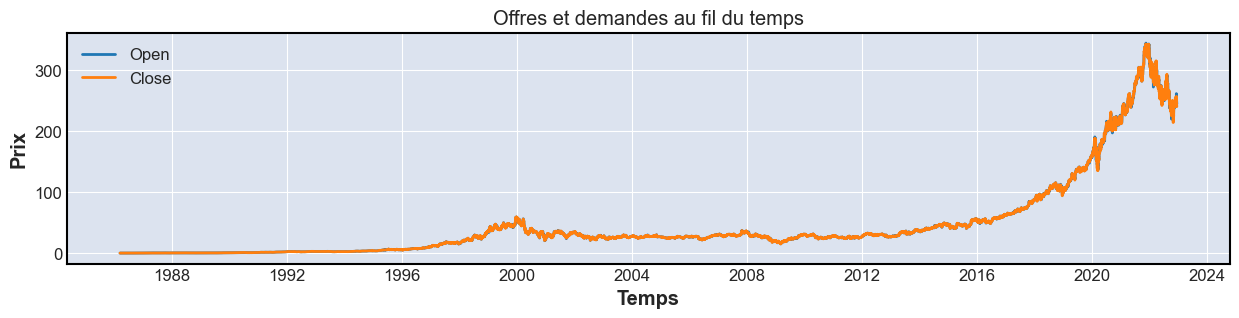

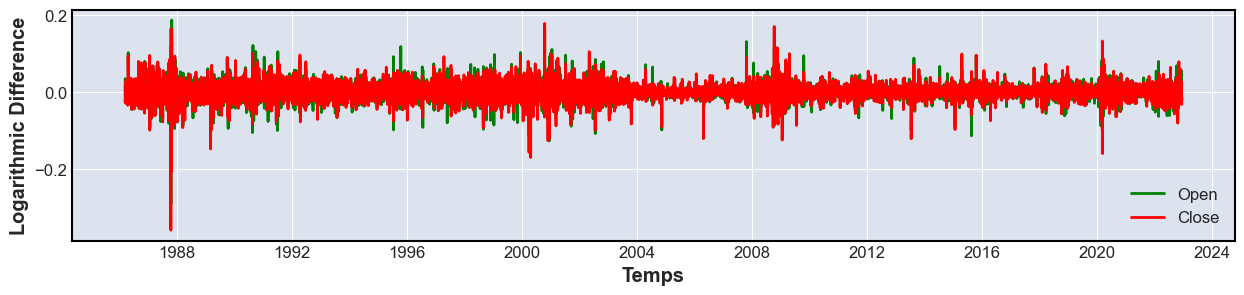

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\3197853306.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


In [58]:
f = plt.figure(1, figsize=(15,3))
plt.plot(df['Open'], label='Open')
plt.plot(df['Close'], label='Close')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.title('Offres et demandes au fil du temps')
plt.legend()
f.show()

g = plt.figure(2, figsize=(15,3))
plt.plot(df["Open_logdiff"], label="Open",color='green')
plt.plot(df["Close_logdiff"], label="Close",color='red')
plt.xlabel("Temps")
plt.ylabel("Logarithmic Difference")
plt.legend()
plt.show()
g.show()

In [59]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'price_change',
       'target', 'Open_logdiff', 'Close_logdiff', 'High_logdiff',
       'Low_logdiff'],
      dtype='object')

In [60]:
df.isna().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
price_change     0
target           0
Open_logdiff     1
Close_logdiff    1
High_logdiff     1
Low_logdiff      1
dtype: int64

In [61]:
df.shape, df.shape

((9268, 12), (9268, 12))

In [62]:
df = df.dropna()
df = df.reset_index(drop=True)

In [63]:
df.shape, df.shape

((9267, 12), (9267, 12))

In [64]:
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'price_change', 
        'Open_logdiff', 'Close_logdiff', 'High_logdiff', 'Low_logdiff']]
y = df['target']

In [65]:
# Séparation des données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_logdiff, X_test_logdiff, y_train_logdiff, y_test_logdiff = train_test_split(X, y, test_size=0.2)

In [157]:
# Entraînement du modèle
clf = RandomForestClassifier()
clf.fit(X_train.values, y_train)

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\1624189685.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train.values, y_train)


RandomForestClassifier()

In [158]:
# Evaluation du modèle
y_pred = clf.predict(X_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy:  0.5075512405609492
Confusion Matrix: 
 [[497 429]
 [484 444]]


#### ------------------------

In [164]:
df_ = df[['Open', 'High', 'Low', 'Close', 'Volume', 'target']]
df_

,Open,High,Low,Close,Volume,target
0,0.100694,0.103299,0.100694,0.102431,133171200,1
1,0.102431,0.103299,0.098958,0.099826,67766400,0
2,0.099826,0.100694,0.097222,0.098090,47894400,0
3,0.098090,0.098090,0.094618,0.095486,58435200,0
4,0.095486,0.097222,0.091146,0.092882,59990400,0
...,...,...,...,...,...,...
9262,261.690002,263.920013,253.070007,256.920013,42196900,0
9263,257.130005,262.589996,254.309998,257.220001,35410900,1
9264,253.720001,254.199997,247.339996,249.009995,35560400,0
9265,248.550003,249.839996,243.509995,244.690002,86088100,0


In [165]:
# écraser les valeurs de la colonne 'target' en haut
df_['target'] = df_['target'].shift(-1)

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\306046214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['target'] = df_['target'].shift(-1)


In [166]:
df_ = df_.iloc[:-1, :]

In [217]:
X__ = df_[['Open', 'High', 'Low', 'Close', 'Volume']]
y__ = df_[['target']]
# X__ = df_[['Open', 'High', 'Low', 'target', 'Volume']]
# y__ = df_[['Close']]

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X__, y__, test_size=0.2)

In [219]:
clf__logdiff = RandomForestClassifier()

clf__logdiff.fit(X_train.values, y_train)

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\1086334318.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf__logdiff.fit(X_train.values, y_train)


RandomForestClassifier()

In [220]:
# Evaluation du modèle
y_pred_ = clf__logdiff.predict(X_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_))

Accuracy:  0.48623853211009177
Confusion Matrix: 
 [[487 444]
 [508 414]]


In [224]:
clf__logdiff_2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [20, 40, 60, 80, 100, 140, 160, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf__logdiff, param_grid=param_grid, cv= 5)
CV_rfc.fit(X__.values, y__)

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=700),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 40, 60, 80, 100, 140, 160, 200]})

In [225]:
clf__logdiff = CV_rfc.best_estimator_
print(CV_rfc.best_params_)
# Evaluation du modèle
y_pred_ = CV_rfc.predict(X__.values)
print("Accuracy: ", accuracy_score(y__, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y__, y_pred_))

{'max_features': 'log2', 'n_estimators': 40}
Accuracy:  0.999568267674042
Confusion Matrix: 
 [[4679    1]
 [   3 4582]]


#### ------------------------

In [177]:
df_.head()

,Open,High,Low,Close,Volume,target
0,0.100694,0.103299,0.100694,0.102431,133171200,0.0
1,0.102431,0.103299,0.098958,0.099826,67766400,0.0
2,0.099826,0.100694,0.097222,0.098090,47894400,0.0
3,0.098090,0.098090,0.094618,0.095486,58435200,0.0
4,0.095486,0.097222,0.091146,0.092882,59990400,0.0


In [178]:
df_["Open_logdiff"] = np.log(df_["Open"]).diff()
df_["Close_logdiff"] = np.log(df_["Close"]).diff()
df_["High_logdiff"] = np.log(df_["High"]).diff()
df_["Low_logdiff"] = np.log(df_["Low"]).diff()

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\4118126047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["Open_logdiff"] = np.log(df_["Open"]).diff()
C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\4118126047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["Close_logdiff"] = np.log(df_["Close"]).diff()
C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\4118126047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [181]:
df_ = df_.iloc[1:,:]

In [182]:
df_.head()

,Open,High,Low,Close,Volume,target,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
1,0.102431,0.103299,0.098958,0.099826,67766400,0.0,0.017103,-0.025761,0.000000,-0.017391
2,0.099826,0.100694,0.097222,0.098090,47894400,0.0,-0.025761,-0.017543,-0.025541,-0.017698
3,0.098090,0.098090,0.094618,0.095486,58435200,0.0,-0.017543,-0.026906,-0.026201,-0.027149
4,0.095486,0.097222,0.091146,0.092882,59990400,0.0,-0.026906,-0.027650,-0.008888,-0.037385
5,0.092882,0.092882,0.089410,0.090278,65289600,1.0,-0.027650,-0.028436,-0.045667,-0.019230


In [183]:
X__ = df_[['Open', 'High', 'Low', 'Close', 'Volume', 'Open_logdiff', 'Close_logdiff', 'High_logdiff', 'Low_logdiff']]
y__ = df_[['target']]

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X__, y__, test_size=0.2)

In [185]:
clf__logdiff = RandomForestClassifier()
clf__logdiff.fit(X_train.values, y_train)

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\2038467378.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf__logdiff.fit(X_train.values, y_train)


RandomForestClassifier()

In [186]:
# Evaluation du modèle
y_pred_ = clf__logdiff.predict(X_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_))

Accuracy:  0.4910955207771182
Confusion Matrix: 
 [[500 400]
 [543 410]]


In [197]:
from sklearn.model_selection import GridSearchCV

In [226]:
clf__logdiff_2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [20, 40, 60, 80, 100, 140, 160, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf__logdiff_2, param_grid=param_grid, cv= 5)
CV_rfc.fit(X__.values, y__)

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 40, 60, 80, 100, 140, 160, 200]})

In [227]:
clf__logdiff = CV_rfc.best_estimator_

In [228]:
CV_rfc.best_params_

{'max_features': 'sqrt', 'n_estimators': 80}

In [229]:
# Evaluation du modèle
y_pred_ = clf__logdiff.predict(X__.values)
print("Accuracy: ", accuracy_score(y__, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y__, y_pred_))

Accuracy:  1.0
Confusion Matrix: 
 [[4680    0]
 [   0 4585]]


In [214]:
clf__logdiff_2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [20, 40, 60, 80, 100, 140, 160, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf__logdiff_2, param_grid=param_grid, cv= 5)
CV_rfc.fit(X__.values, y__)

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 40, 60, 80, 100, 140, 160, 200]})

In [215]:
clf__logdiff = CV_rfc.best_estimator_
CV_rfc.best_params_

{'max_features': 'sqrt', 'n_estimators': 20}

In [216]:
# Evaluation du modèle
y_pred_ = clf__logdiff.predict(X__.values)
print("Accuracy: ", accuracy_score(y__, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y__, y_pred_))

Accuracy:  0.9973016729627631
Confusion Matrix: 
 [[4675    5]
 [  20 4565]]


#### ------------------------

In [230]:
df_2 = df_.copy()

In [231]:
df_2.head()

,Open,High,Low,Close,Volume,target,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
1,0.102431,0.103299,0.098958,0.099826,67766400,0.0,0.017103,-0.025761,0.000000,-0.017391
2,0.099826,0.100694,0.097222,0.098090,47894400,0.0,-0.025761,-0.017543,-0.025541,-0.017698
3,0.098090,0.098090,0.094618,0.095486,58435200,0.0,-0.017543,-0.026906,-0.026201,-0.027149
4,0.095486,0.097222,0.091146,0.092882,59990400,0.0,-0.026906,-0.027650,-0.008888,-0.037385
5,0.092882,0.092882,0.089410,0.090278,65289600,1.0,-0.027650,-0.028436,-0.045667,-0.019230


In [232]:
def scl(x, max_):
    return x/max_

In [233]:
for c in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_2[c] = df_2[c].apply(lambda x: scl(x, df_2[c].max()))

In [234]:
df_2.head()

,Open,High,Low,Close,Volume,target,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
1,0.000297,0.000295,0.000289,0.000291,0.085923,0.0,0.017103,-0.025761,0.000000,-0.017391
2,0.000290,0.000288,0.000284,0.000286,0.060727,0.0,-0.025761,-0.017543,-0.025541,-0.017698
3,0.000285,0.000281,0.000276,0.000278,0.074092,0.0,-0.017543,-0.026906,-0.026201,-0.027149
4,0.000277,0.000278,0.000266,0.000271,0.076064,0.0,-0.026906,-0.027650,-0.008888,-0.037385
5,0.000270,0.000266,0.000261,0.000263,0.082783,1.0,-0.027650,-0.028436,-0.045667,-0.019230


In [235]:
X__ = df_2[['Open', 'High', 'Low', 'Close', 'Volume', 'Open_logdiff', 'Close_logdiff', 'High_logdiff', 'Low_logdiff']]
y__ = df_2[['target']]

X_train, X_test, y_train, y_test = train_test_split(X__, y__, test_size=0.2)

cc = RandomForestClassifier()
cc.fit(X_train.values, y_train)

# Evaluation du modèle
y_pred_ = cc.predict(X_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_))

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\118907606.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cc.fit(X_train.values, y_train)


Accuracy:  0.4954128440366973
Confusion Matrix: 
 [[493 415]
 [520 425]]


In [236]:
cc2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [10, 15, 20, 40, 60, 80, 100, 140, 160, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=cc2, param_grid=param_grid, cv= 5)
CV_rfc.fit(X__.values, y__)

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train,

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 15, 20, 40, 60, 80, 100, 140, 160,
                                          200]})

In [238]:
clf__logdiff = CV_rfc.best_estimator_
print(CV_rfc.best_params_)

# Evaluation du modèle
y_pred_ = clf__logdiff.predict(X__.values)
print("Accuracy: ", accuracy_score(y__, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y__, y_pred_))

{'max_features': 'log2', 'n_estimators': 10}
Accuracy:  0.9835941716135995
Confusion Matrix: 
 [[4661   19]
 [ 133 4452]]


#### ------------------------

In [68]:
clf_logdiff = RandomForestClassifier()

clf_logdiff.fit(X_train_logdiff.values, y_train_logdiff)

RandomForestClassifier()

In [69]:
# Evaluation du modèle
y_pred_logdiff = clf_logdiff.predict(X_test_logdiff.values)
print("Accuracy: ", accuracy_score(y_test_logdiff, y_pred_logdiff))
print("Confusion Matrix: \n", confusion_matrix(y_test_logdiff, y_pred_logdiff))

Accuracy:  1.0
Confusion Matrix: 
 [[957   0]
 [  0 897]]


In [239]:
X_test.iloc[1,:]

Open             0.080669
High             0.079847
Low              0.080742
Close            0.081344
Volume           0.031384
Open_logdiff    -0.004307
Close_logdiff    0.002152
High_logdiff    -0.002861
Low_logdiff     -0.005414
Name: 6254, dtype: float64

In [240]:
X_test.iloc[1,:]*np.abs(np.random.randn())

Open             0.021579
High             0.021359
Low              0.021598
Close            0.021759
Volume           0.008395
Open_logdiff    -0.001152
Close_logdiff    0.000576
High_logdiff    -0.000765
Low_logdiff     -0.001448
Name: 6254, dtype: float64

In [245]:
# Utilisation du modèle pour prédire les tendances du marché boursier pour des périodes futures
new_data = np.array(X_test.iloc[1,:]*np.random.randn()).reshape(1, -1)
prediction = clf__logdiff.predict(new_data)
if prediction == 1:
    print("Restez dans le marché")
else:
    print("Quittez le marché")

Restez dans le marché


In [248]:
# Utilisation du modèle pour prédire les tendances du marché boursier pour des périodes futures
new_data = np.array(X_test_logdiff.iloc[1,:]*np.random.randn()).reshape(1, -1)
prediction = clf_logdiff.predict(new_data)
if prediction == 1:
    print("Restez dans le marché")
else:
    print("Quittez le marché")

Quittez le marché


## 02. Using Decision Tree - To Predict if I will stay in market or non

In [74]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
# Entraînement du modèle
dtree = DecisionTreeClassifier()
dtree.fit(X_train.values, y_train)

# Evaluation du modèle
y_pred = dtree.predict(X_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy:  1.0
Confusion Matrix: 
 [[912   0]
 [  0 942]]


In [76]:
# Entraînement du modèle
dtree_logdiff = DecisionTreeClassifier()
dtree_logdiff.fit(X_train_logdiff.values, y_train_logdiff)

# Evaluation du modèle
y_pred_logdiff = dtree_logdiff.predict(X_test_logdiff.values)
print("Accuracy: ", accuracy_score(y_test_logdiff, y_pred_logdiff))
print("Confusion Matrix: \n", confusion_matrix(y_test_logdiff, y_pred_logdiff))

Accuracy:  1.0
Confusion Matrix: 
 [[957   0]
 [  0 897]]


In [77]:
X_train.head()

,Open,High,Low,Close,Adj Close,Volume,price_change,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
8693,213.399994,214.740005,204.110001,205.369995,201.245316,35461500,-8.029999,0.027555,-0.028418,-0.000466,-0.012609
5420,28.629999,28.950001,28.580000,28.930000,21.168192,34380800,0.300001,-0.001396,0.015677,0.006932,0.005966
796,0.359375,0.371528,0.357639,0.368056,0.230205,54590400,0.008681,-0.004819,0.028711,0.023643,0.009756
4350,24.670000,24.959999,24.420000,24.879999,15.611506,75768600,0.209999,0.030037,0.008071,0.008449,0.023618
3450,42.406250,45.375000,42.187500,44.968750,28.126198,243819200,2.562500,-0.079306,-0.017907,-0.023146,-0.070079


In [78]:
X_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'price_change',
       'Open_logdiff', 'Close_logdiff', 'High_logdiff', 'Low_logdiff'],
      dtype='object')

In [79]:
subX_train = X_train[['Open', 'Close', 'Volume']]
subX_test = X_test[['Open', 'Close', 'Volume']]

In [80]:
# Entraînement du modèle
dtree_subset = DecisionTreeClassifier()
dtree_subset.fit(subX_train.values, y_train)

# Evaluation du modèle
y_pred_subset = dtree_subset.predict(subX_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_subset))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_subset))

Accuracy:  0.7659115426105717
Confusion Matrix: 
 [[698 214]
 [220 722]]


## 03. Feature Select  

Il existe plusieurs algorithmes de sélection de caractéristiques que vous pouvez utiliser pour déterminer les attributs qui ont le plus d'impact sur la performance de votre modèle de prédiction. Certains des algorithmes les plus courants incluent :

###### 1. Sélection de caractéristiques basée sur la corrélation : 

Cet algorithme utilise la corrélation entre les caractéristiques et la cible pour sélectionner les caractéristiques les plus pertinentes. Il peut être utilisé pour éliminer les caractéristiques qui ont une corrélation négative ou faible avec la cible.

In [81]:
# calcul de la corrélation des variables
corr = X.corr()

# sélectionner les variables avec une corrélation absolue supérieure à un certain seuil
corr_var = corr[abs(corr) > 0.5]

# sélectionner les variables avec une corrélation absolue supérieure à un certain seuil
final_var = corr_var.dropna(axis=1, how='all')

# afficher les variables sélectionnées
print("Variables sélectionnées : ", final_var)

Variables sélectionnées :                     Open      High       Low     Close  Adj Close  Volume  \
Open           1.000000  0.999932  0.999921  0.999837   0.997979     NaN   
High           0.999932  1.000000  0.999894  0.999916   0.998018     NaN   
Low            0.999921  0.999894  1.000000  0.999922   0.998096     NaN   
Close          0.999837  0.999916  0.999922  1.000000   0.998138     NaN   
Adj Close      0.997979  0.998018  0.998096  0.998138   1.000000     NaN   
Volume              NaN       NaN       NaN       NaN        NaN     1.0   
price_change        NaN       NaN       NaN       NaN        NaN     NaN   
Open_logdiff        NaN       NaN       NaN       NaN        NaN     NaN   
Close_logdiff       NaN       NaN       NaN       NaN        NaN     NaN   
High_logdiff        NaN       NaN       NaN       NaN        NaN     NaN   
Low_logdiff         NaN       NaN       NaN       NaN        NaN     NaN   

               price_change  Open_logdiff  Close_logdiff  Hi

###### 2. Recherche aléatoire : 

Cet algorithme utilise une recherche aléatoire pour sélectionner des caractéristiques aléatoires et évaluer leur impact sur la performance du modèle. Il peut être utilisé pour sélectionner les caractéristiques les plus pertinentes pour un modèle donné.

In [82]:
from sklearn.model_selection import RandomizedSearchCV

In [83]:
param_dist = {"n_estimators": [50, 100, 200],
              "max_depth": [3, 5, 7]}

# Appliquer la recherche aléatoire
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5)
random_search.fit(X, y)

# Afficher les meilleurs paramètres
print("Best parameters: ", random_search.best_params_)

Best parameters:  {'n_estimators': 200, 'max_depth': 5}


In [84]:
Xx2 = X_train[['price_change', 'Close_logdiff', 'High_logdiff']]
Xt2 = X_test[['price_change', 'Close_logdiff', 'High_logdiff']]

In [85]:
# Entraînement du modèle
dtree_subset = RandomForestClassifier()
dtree_subset.fit(Xx2.values, y_train)

# Evaluation du modèle
y_pred_subset = dtree_subset.predict(Xt2.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_subset))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_subset))

Accuracy:  1.0
Confusion Matrix: 
 [[912   0]
 [  0 942]]


In [86]:
# Entraînement du modèle
dtree_subset = RandomForestClassifier(n_estimators=100, max_depth=3) # pour eviter l'overfitting
dtree_subset.fit(Xx2.values, y_train)

# Evaluation du modèle
y_pred_subset = dtree_subset.predict(Xt2.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_subset))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_subset))

Accuracy:  1.0
Confusion Matrix: 
 [[912   0]
 [  0 942]]


###### 3. Sélection de caractéristiques basée sur l'importance : 

Cet algorithme utilise l'importance des caractéristiques déterminée par un modèle de machine learning pour sélectionner les caractéristiques les plus pertinentes. Il peut être utilisé pour sélectionner les caractéristiques les plus pertinentes pour un modèle donné.

In [87]:
from sklearn.feature_selection import SelectFromModel

In [249]:
# Entraînement du modèle
rf_importance = RandomForestClassifier(n_estimators=10) # pour eviter l'overfitting
rf_importance.fit(X.values, y)

# afficher les importances des caractéristiques
print("Importance des caractéristiques : ", rf_importance.feature_importances_)

# sélectionner les caractéristiques les plus importantes
sfm = SelectFromModel(rf_importance, threshold=0.05)
sfm.fit(X, y)
X_important = sfm.transform(X)

# afficher les caractéristiques sélectionnées
print("Caractéristiques sélectionnées : ", X_important)

Importance des caractéristiques :  [0.00230449 0.00220138 0.00234967 0.00185125 0.00289867 0.00357311
 0.58846154 0.01324884 0.27862374 0.07709262 0.0273947 ]
Caractéristiques sélectionnées :  [[ 1.73700000e-03  1.71031861e-02]
 [-2.60500000e-03 -2.57607307e-02]
 [-1.73600000e-03 -1.75432459e-02]
 ...
 [-4.71000600e+00 -3.24387175e-02]
 [-3.86000100e+00 -1.75009248e-02]
 [-4.41000400e+00 -1.74799562e-02]]


In [254]:
# afficher les importances des caractéristiques
print("Importance des caractéristiques : ", clf__logdiff.feature_importances_)

# sélectionner les caractéristiques les plus importantes
sfm = SelectFromModel(rf_importance, threshold=0.05)
sfm.fit(X, y)
X_important = sfm.transform(X)

# afficher les caractéristiques sélectionnées
print("Caractéristiques sélectionnées : ", X_important)

Importance des caractéristiques :  [0.08844959 0.08934238 0.08476644 0.08764284 0.13743997 0.12241083
 0.12898427 0.13174118 0.1292225 ]
Caractéristiques sélectionnées :  [[ 1.73700000e-03  1.71031861e-02]
 [-2.60500000e-03 -2.57607307e-02]
 [-1.73600000e-03 -1.75432459e-02]
 ...
 [-4.71000600e+00 -3.24387175e-02]
 [-3.86000100e+00 -1.75009248e-02]
 [-4.41000400e+00 -1.74799562e-02]]


In [255]:
X.columns[sfm.get_support()]

Index(['price_change', 'Close_logdiff'], dtype='object')

In [258]:
X__ = df[['price_change', 'Close_logdiff']]
y__ = df[['target']]

In [259]:
X__

,price_change,Close_logdiff
0,0.001737,0.017103
1,-0.002605,-0.025761
2,-0.001736,-0.017543
3,-0.002604,-0.026906
4,-0.002604,-0.027650
...,...,...
9262,-4.769989,0.017314
9263,0.089996,0.001167
9264,-4.710006,-0.032439
9265,-3.860001,-0.017501


In [260]:
X_train, X_test, y_train, y_test = train_test_split(X__, y__, test_size=0.2)

cc = RandomForestClassifier()
cc.fit(X_train.values, y_train)

# Evaluation du modèle
y_pred_ = cc.predict(X_test.values)
print("Accuracy: ", accuracy_score(y_test, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_))

C:\Users\Soufiane\AppData\Local\Temp\ipykernel_6084\3938139035.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cc.fit(X_train.values, y_train)


Accuracy:  1.0
Confusion Matrix: 
 [[945   0]
 [  0 909]]


In [265]:
cc.n_estimators

100

In [266]:
cc2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

param_grid = { 
    'n_estimators': [5, 7, 10, 15, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=cc2, param_grid=param_grid, cv= 5)
CV_rfc.fit(X__.values, y__)

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train,

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train,

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB s

C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Soufiane\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train,

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [5, 7, 10, 15, 20, 30]})

In [267]:
clf__logdiff = CV_rfc.best_estimator_
print(CV_rfc.best_params_)

# Evaluation du modèle
y_pred_ = clf__logdiff.predict(X__.values)
print("Accuracy: ", accuracy_score(y__, y_pred_))
print("Confusion Matrix: \n", confusion_matrix(y__, y_pred_))

{'max_features': 'auto', 'n_estimators': 5}
Accuracy:  1.0
Confusion Matrix: 
 [[4681    0]
 [   0 4586]]


###### 4. Sélection de caractéristiques basée sur le filtrage: 

Cet algorithme utilise des méthodes telles que la corrélation des variables, la régression linéaire, la régression logistique ou l'analyse discriminante pour évaluer l'importance de chaque variable dans le modèle.

## 04. Predict Close price

## 05. Using LSTM - Deep Learning based

In [90]:
df.drop("Adj Close",axis=1,inplace=True)

In [279]:
df.head()

,Open,High,Low,Close,Volume,price_change,target,Open_logdiff,Close_logdiff,High_logdiff,Low_logdiff
0,0.100694,0.103299,0.100694,0.102431,133171200,0.001737,1,0.035089,0.017103,0.008438,0.035089
1,0.102431,0.103299,0.098958,0.099826,67766400,-0.002605,0,0.017103,-0.025761,0.000000,-0.017391
2,0.099826,0.100694,0.097222,0.098090,47894400,-0.001736,0,-0.025761,-0.017543,-0.025541,-0.017698
3,0.098090,0.098090,0.094618,0.095486,58435200,-0.002604,0,-0.017543,-0.026906,-0.026201,-0.027149
4,0.095486,0.097222,0.091146,0.092882,59990400,-0.002604,0,-0.026906,-0.027650,-0.008888,-0.037385


In [280]:
df.shape

(9267, 11)

### 1 -  In order to develop our trading strategy, we need to obtain a dataframe with the monthly means and the first trading day of the month price.

#### 1.1 - First we obtain the monthly means

Note the difference in the dates of the index. For 'MS' the dates of the groups are always the first of the month, for 'M' the last day.

#### 1.2 - Then we obtain the list of the first trading day for each month

In [ ]:
start_date = datetime.datetime(1986, 3, 31)
end_date = datetime.datetime(2022,12,30)

start_year = start_date.year
start_month = start_date.month
end_year = end_date.year
end_month = end_date.month

first_days = []
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))

# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))

# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

In [ ]:
first_days

Now for each month we have the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price).

The feature *`rapp`* is the quotient between **the open price of the first trading day of the next month** and **the open price of the first trading day of the current month**. 

It will be used because it gives ***the variation of the portfolio for the current month**

In [ ]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [ ]:
dfm.head()

In [ ]:
dfm.tail()

Now we add the columns corresponding to the moving averages at 1 and 2 years

In [ ]:
dfm["Open"].rolling(window=12).mean()

In [ ]:
dfm["Open"].rolling(window=12).mean().shift(1)

In [ ]:
dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)

In [ ]:
dfm

Note that in this way each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)

In [ ]:
dfm.loc["1986-03","mv_avg_12"]

In [ ]:
dfm.loc["1986-12","mv_avg_12"]

In [ ]:
(3 + 12) // 12, (3 + 12) % 12

In [ ]:
dfm.loc["1987-02","mv_avg_12"]

In [ ]:
dfm.loc["1987-03","mv_avg_12"]

In [ ]:
dfm.loc["1987-03","mv_avg_24"]

In [ ]:
(3 + 24) // 12, (3 + 24) % 12

1986-03 -> 1988-06

In [ ]:
dfm.loc["1988-06","mv_avg_24"]

In [ ]:
dfm.loc["1990-01":"1991-02","Open"]

In [ ]:
dfm.loc["1990-01":"1991-02","Open"].mean()

We remove the first 24 months, since they do not have the 2-year moving average

In [ ]:
dfm.iloc[:24+1,:]

In [ ]:
dfm = dfm.iloc[24:,:] # WARNING: DO IT JUST ONE TIME!
print(dfm.index)

Finally, we can divide *dfm* in train and test set

In [ ]:
dfm.shape

In [ ]:
mtest=72
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 

In [ ]:
train.shape, test.shape

## Part 2: Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *rapp*.
The following function explains how: the vector v selects which months we are going to stay in the market

- `Gross yield ` : is the overall return on an investment without deducting taxes and expenses. Gross yield may be used to compare the relative returns of various investments including bonds, mutual funds, and rental property. 
- `Net yield` :  is the real return to the investor.

<img src="gross yield Vs. net yield.png">

In [268]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We just need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction

In [269]:
tax_cg  = 0.26
comm_bk = 0.001

#### This function `expand_islands2D` will be used in the function `yield_net`

Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v and their number.

For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

In [270]:
def expand_islands2D(v):
    
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

#### Examples :

In [271]:
expand_islands2D([0,1,1,0,1,0,1])

(array([[0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]], dtype=int32),
 3)

In [272]:
expand_islands2D([0,1,1,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1])

(array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
       dtype=int32),
 6)

Again, the vector v selects which months we are going to stay in the market

#### This function `yield_net` returns the total percentage net yield and the annual percentage net yield

In [273]:
def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

## Part 3: Define the LSTM model

We want to use a `LSTM neural network` to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and **at each step we want to predict the opening price of the first day of the next month**: in this way we will be able to **find the vector v** which ***selects the months during which we are going to stay in the market**.

In [277]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [ ]:
train_test_1 = train.copy()
create_window(train, window_size=2)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dg = pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))

In [ ]:
dfm[["High","Low","Open","Close","Volume","fd_cm_open", "mv_avg_12","mv_avg_24","fd_nm_open"]]

In [ ]:
dg

In [ ]:
dg0 = dg[[0,1,2,3,4,5,6,7]]
dg0

In [ ]:
window = 4
dfw = create_window(dg0,window)

In [ ]:
dfw

In [ ]:
dfw.columns

In [ ]:
dfw.shape

In [ ]:
X_dfw = np.reshape(dfw.values,(dfw.shape[0],window+1,8))
X_dfw.shape

In [ ]:
dfw.iloc[:4,:]

In [ ]:
X_dfw[0,:,:]

In [ ]:
y_dfw = np.array(dg[8][window:])

In [ ]:
y_dfw

In [ ]:
X_trainw = X_dfw[:-mtest-1,:,:]
X_testw = X_dfw[-mtest-1:,:,:]
y_trainw = y_dfw[:-mtest-1]
y_testw = y_dfw[-mtest-1:]

In [ ]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

In [ ]:
model = model_lstm(window+1,8)

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_trainw, y_trainw, epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=0, callbacks=[],shuffle=False)

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_pr = model.predict(X_trainw)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [ ]:
y_pred=model.predict(X_testw)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on test set",fontsize=25)
plt.show()

**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vector v indicates the "in months" (as 1s) and "out months" (as 0s)**

In [ ]:
y_pred

In [ ]:
np.diff(y_pred.reshape(y_pred.shape[0]),1)

In [ ]:
np.sign(v)

In [ ]:
np.maximum(np.sign(v),0)

In [ ]:
v      = np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm = np.maximum(np.sign(v),0)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our model: it is quite good at predicting the sign of the first derivative of the index, but this is exactly what we need for our trading strategy!** 

## Part 4: Compare the LSTM method with other methods

Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [ ]:
v_bh = np.ones(test.shape[0])
v_ma = test["fd_cm_open"] > test["mv_avg_12"]

In [ ]:
def gross_portfolio(df,w):
    portfolio = [(w * df["rapp"] + (1-w))[:i].prod() for i in range(len(w))]
    return portfolio

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [ ]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results0=pd.DataFrame({})
results1=pd.DataFrame({})
results2=pd.DataFrame({})
results3=pd.DataFrame({})

results0["Method"]=["Buy and hold","Moving average","LSTM"]
results1["Method"]=["Buy and hold","Moving average","LSTM"]
results2["Method"]=["Buy and hold","Moving average","LSTM"]
results3["Method"]=["Buy and hold","Moving average","LSTM"]

vs=[v_bh,v_ma,v_lstm]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results2["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results3["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)
print("\n")
print(results2)
print("\n")
print(results3)